In [1]:
import numpy as np

def rmse(y, yhat):
    return np.mean((y - yhat)**2)

In [2]:
np.random.seed(123)
n = 5000
nval = 2500
Z = np.random.uniform(0, 1, size=n)
dgp = 2

In [3]:
if dgp == 1:
    # dgp that favors the x-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * np.ones(z.shape)

In [4]:
if dgp == 2:
    # dgp that favors the dr-learner
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: (.5 + .1 * (z<=.4) * (z>=.2))

In [5]:
if dgp == 3:
    # dgp that favors the r-learner
    prop = lambda z: .5 - .49 * (z<=.6) * (z>=.3)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * z**2

In [6]:
if dgp == 4:
    # dgp that favors the covariate shift X-learner over X-learner
    prop = lambda z: .5 - .49 * (z<=.6) * (z>=.3)
    base = lambda z: .1 * (z<=.8) * (z>=.6)
    cate = lambda z: .5 * z**2 * (z<=.6) + .18

In [7]:
if dgp == 5:
    # dgp that removes superiority of X-learner strategy
    prop = lambda z: .05 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [8]:
if dgp == 6:
    # dgp that favors the opposite of the X-learner strategy
    prop = lambda z: .95 * np.ones(z.shape)
    base = lambda z: .1 * np.ones(z.shape)
    cate = lambda z: .5 * (z<=.8) * (z>=.5)

In [9]:
D = np.random.binomial(1, prop(Z))
Y = cate(Z) * D + base(Z) + np.random.normal(0, .05, size=n)

In [10]:
ntest = 1000
Ztest = np.random.uniform(0, 1, size=ntest)
Ztest = np.sort(Ztest)

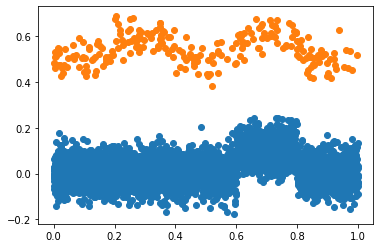

In [11]:
import matplotlib.pyplot as plt

plt.scatter(Z[D==0], Y[D==0])
plt.scatter(Z[D==1], Y[D==1])
plt.show()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [20, 50]
}
reg = lambda: GridSearchCV(RandomForestRegressor(random_state=123), param_grid)
clf = lambda: GridSearchCV(RandomForestClassifier(random_state=123), param_grid)

In [13]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)])
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val])
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)])
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20, verbosity=0)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0)

In [14]:
Z = Z.reshape(-1, 1)
g0 = reg().fit(Z[D==0], Y[D==0])
g1 = reg().fit(Z[D==1], Y[D==1])

[0]	validation_0-rmse:0.458763
[1]	validation_0-rmse:0.436103
[2]	validation_0-rmse:0.414591
[3]	validation_0-rmse:0.394167
[4]	validation_0-rmse:0.374783
[5]	validation_0-rmse:0.356384
[6]	validation_0-rmse:0.338923
[7]	validation_0-rmse:0.322354
[8]	validation_0-rmse:0.306632
[9]	validation_0-rmse:0.291718
[10]	validation_0-rmse:0.277571
[11]	validation_0-rmse:0.264156
[12]	validation_0-rmse:0.251434
[13]	validation_0-rmse:0.239375
[14]	validation_0-rmse:0.227946
[15]	validation_0-rmse:0.217116
[16]	validation_0-rmse:0.206854
[17]	validation_0-rmse:0.197139
[18]	validation_0-rmse:0.18794
[19]	validation_0-rmse:0.179235
[20]	validation_0-rmse:0.170997
[21]	validation_0-rmse:0.163209
[22]	validation_0-rmse:0.155847
[23]	validation_0-rmse:0.148892
[24]	validation_0-rmse:0.142323
[25]	validation_0-rmse:0.136126
[26]	validation_0-rmse:0.13028
[27]	validation_0-rmse:0.124771
[28]	validation_0-rmse:0.119574
[29]	validation_0-rmse:0.11469
[30]	validation_0-rmse:0.110097
[31]	validation_0-rms

[253]	validation_0-rmse:0.051434
[254]	validation_0-rmse:0.051438
[255]	validation_0-rmse:0.051438
[256]	validation_0-rmse:0.051435
[257]	validation_0-rmse:0.051435
[258]	validation_0-rmse:0.051435
[259]	validation_0-rmse:0.051435
[260]	validation_0-rmse:0.051435
[261]	validation_0-rmse:0.051433
[262]	validation_0-rmse:0.051434
[263]	validation_0-rmse:0.051437
[264]	validation_0-rmse:0.051435
[265]	validation_0-rmse:0.051436
[266]	validation_0-rmse:0.051433
[267]	validation_0-rmse:0.051429
[268]	validation_0-rmse:0.051428
[269]	validation_0-rmse:0.051429
[270]	validation_0-rmse:0.05143
[271]	validation_0-rmse:0.051427
[272]	validation_0-rmse:0.051427
[273]	validation_0-rmse:0.051427
[274]	validation_0-rmse:0.051425
[275]	validation_0-rmse:0.051427
[276]	validation_0-rmse:0.051431
[277]	validation_0-rmse:0.051431
[278]	validation_0-rmse:0.051433
[279]	validation_0-rmse:0.051431
[280]	validation_0-rmse:0.051432
[281]	validation_0-rmse:0.051433
[282]	validation_0-rmse:0.051434
[283]	valid

[3]	validation_0-rmse:0.069853
[4]	validation_0-rmse:0.06857
[5]	validation_0-rmse:0.067438
[6]	validation_0-rmse:0.066403
[7]	validation_0-rmse:0.065445
[8]	validation_0-rmse:0.064442
[9]	validation_0-rmse:0.063593
[10]	validation_0-rmse:0.0627
[11]	validation_0-rmse:0.061953
[12]	validation_0-rmse:0.061316
[13]	validation_0-rmse:0.060566
[14]	validation_0-rmse:0.059942
[15]	validation_0-rmse:0.059332
[16]	validation_0-rmse:0.058777
[17]	validation_0-rmse:0.05817
[18]	validation_0-rmse:0.0577
[19]	validation_0-rmse:0.057155
[20]	validation_0-rmse:0.056716
[21]	validation_0-rmse:0.05627
[22]	validation_0-rmse:0.055603
[23]	validation_0-rmse:0.055164
[24]	validation_0-rmse:0.054568
[25]	validation_0-rmse:0.054181
[26]	validation_0-rmse:0.053669
[27]	validation_0-rmse:0.053326
[28]	validation_0-rmse:0.052846
[29]	validation_0-rmse:0.05257
[30]	validation_0-rmse:0.052158
[31]	validation_0-rmse:0.051885
[32]	validation_0-rmse:0.051499
[33]	validation_0-rmse:0.051257
[34]	validation_0-rmse:

[256]	validation_0-rmse:0.046276
[257]	validation_0-rmse:0.046282
[258]	validation_0-rmse:0.046282
[259]	validation_0-rmse:0.046282
[260]	validation_0-rmse:0.046285
[261]	validation_0-rmse:0.046304
[262]	validation_0-rmse:0.046289
[263]	validation_0-rmse:0.046299
[264]	validation_0-rmse:0.046312
[265]	validation_0-rmse:0.046327
[266]	validation_0-rmse:0.046304
[267]	validation_0-rmse:0.046324
[268]	validation_0-rmse:0.046324
[269]	validation_0-rmse:0.046324
[270]	validation_0-rmse:0.046331
[271]	validation_0-rmse:0.046333
[272]	validation_0-rmse:0.046343
[273]	validation_0-rmse:0.046327
[274]	validation_0-rmse:0.046317
[275]	validation_0-rmse:0.04632
[276]	validation_0-rmse:0.04633
[277]	validation_0-rmse:0.046343
[278]	validation_0-rmse:0.04631
[279]	validation_0-rmse:0.04633
[280]	validation_0-rmse:0.046336
[281]	validation_0-rmse:0.046336
[282]	validation_0-rmse:0.046326
[283]	validation_0-rmse:0.046345
[284]	validation_0-rmse:0.046348
[285]	validation_0-rmse:0.04635
[286]	validatio

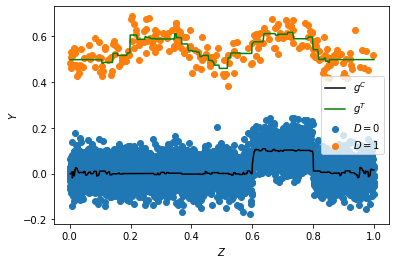

In [16]:
plt.scatter(Z[D==0], Y[D==0], label='$D=0$')
plt.scatter(Z[D==1], Y[D==1], label='$D=1$')
plt.plot(Ztest, g0.predict(Ztest.reshape(-1, 1)), color='black', label='$g^C$')
plt.plot(Ztest, g1.predict(Ztest.reshape(-1, 1)), color='green', label='$g^T$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [17]:
from aggregation import experiment_dr

mses, cates, nuisances = experiment_dr(dgp=dgp, n=n, scale=0.05, random_state=123, reg=reg, clf=clf)

123
Fitting meta learners on dtrain
[0]	validation_0-rmse:0.456251
[1]	validation_0-rmse:0.433664
[2]	validation_0-rmse:0.412219
[3]	validation_0-rmse:0.391862
[4]	validation_0-rmse:0.372537
[5]	validation_0-rmse:0.354195
[6]	validation_0-rmse:0.336787
[7]	validation_0-rmse:0.320268
[8]	validation_0-rmse:0.304594
[9]	validation_0-rmse:0.289723
[10]	validation_0-rmse:0.275617
[11]	validation_0-rmse:0.262238
[12]	validation_0-rmse:0.249551
[13]	validation_0-rmse:0.237523
[14]	validation_0-rmse:0.226118
[15]	validation_0-rmse:0.215314
[16]	validation_0-rmse:0.205079
[17]	validation_0-rmse:0.195384
[18]	validation_0-rmse:0.186201
[19]	validation_0-rmse:0.177516
[20]	validation_0-rmse:0.169298
[21]	validation_0-rmse:0.161525
[22]	validation_0-rmse:0.154171
[23]	validation_0-rmse:0.147225
[24]	validation_0-rmse:0.140667
[25]	validation_0-rmse:0.134475
[26]	validation_0-rmse:0.128633
[27]	validation_0-rmse:0.123129
[28]	validation_0-rmse:0.117944
[29]	validation_0-rmse:0.113062
[30]	validatio

[252]	validation_0-rmse:0.049988
[253]	validation_0-rmse:0.049987
[254]	validation_0-rmse:0.049989
[255]	validation_0-rmse:0.049989
[256]	validation_0-rmse:0.049989
[257]	validation_0-rmse:0.049992
[258]	validation_0-rmse:0.049992
[259]	validation_0-rmse:0.049992
[260]	validation_0-rmse:0.049993
[261]	validation_0-rmse:0.04999
[262]	validation_0-rmse:0.049989
[263]	validation_0-rmse:0.049991
[264]	validation_0-rmse:0.049995
[265]	validation_0-rmse:0.049996
[266]	validation_0-rmse:0.049996
[267]	validation_0-rmse:0.049996
[268]	validation_0-rmse:0.049996
[269]	validation_0-rmse:0.049995
[270]	validation_0-rmse:0.049995
[271]	validation_0-rmse:0.049994
[272]	validation_0-rmse:0.049999
[273]	validation_0-rmse:0.05
[274]	validation_0-rmse:0.05
[275]	validation_0-rmse:0.05
[276]	validation_0-rmse:0.05
[277]	validation_0-rmse:0.05
[278]	validation_0-rmse:0.05
[279]	validation_0-rmse:0.050002
[280]	validation_0-rmse:0.049998
[281]	validation_0-rmse:0.050001
[282]	validation_0-rmse:0.050002
[2

[2]	validation_0-rmse:0.06927
[3]	validation_0-rmse:0.067945
[4]	validation_0-rmse:0.066976
[5]	validation_0-rmse:0.065855
[6]	validation_0-rmse:0.065048
[7]	validation_0-rmse:0.064109
[8]	validation_0-rmse:0.063381
[9]	validation_0-rmse:0.062794
[10]	validation_0-rmse:0.062007
[11]	validation_0-rmse:0.06148
[12]	validation_0-rmse:0.060787
[13]	validation_0-rmse:0.060089
[14]	validation_0-rmse:0.059487
[15]	validation_0-rmse:0.058929
[16]	validation_0-rmse:0.058592
[17]	validation_0-rmse:0.058035
[18]	validation_0-rmse:0.057708
[19]	validation_0-rmse:0.057212
[20]	validation_0-rmse:0.056776
[21]	validation_0-rmse:0.056379
[22]	validation_0-rmse:0.056173
[23]	validation_0-rmse:0.055768
[24]	validation_0-rmse:0.055544
[25]	validation_0-rmse:0.055223
[26]	validation_0-rmse:0.054936
[27]	validation_0-rmse:0.054598
[28]	validation_0-rmse:0.05442
[29]	validation_0-rmse:0.054072
[30]	validation_0-rmse:0.053959
[31]	validation_0-rmse:0.053715
[32]	validation_0-rmse:0.053567
[33]	validation_0-r

[255]	validation_0-rmse:0.042761
[256]	validation_0-rmse:0.042745
[257]	validation_0-rmse:0.042763
[258]	validation_0-rmse:0.042762
[259]	validation_0-rmse:0.042746
[260]	validation_0-rmse:0.042732
[261]	validation_0-rmse:0.042765
[262]	validation_0-rmse:0.042772
[263]	validation_0-rmse:0.042771
[264]	validation_0-rmse:0.042755
[265]	validation_0-rmse:0.042778
[266]	validation_0-rmse:0.042764
[267]	validation_0-rmse:0.042749
[268]	validation_0-rmse:0.042767
[269]	validation_0-rmse:0.042746
[270]	validation_0-rmse:0.042731
[271]	validation_0-rmse:0.042716
[272]	validation_0-rmse:0.042725
[273]	validation_0-rmse:0.042738
[274]	validation_0-rmse:0.042723
[275]	validation_0-rmse:0.042739
[276]	validation_0-rmse:0.042746
[277]	validation_0-rmse:0.042733
[278]	validation_0-rmse:0.04275
[279]	validation_0-rmse:0.042735
[280]	validation_0-rmse:0.042721
[281]	validation_0-rmse:0.042705
[282]	validation_0-rmse:0.042723
[283]	validation_0-rmse:0.042708
[284]	validation_0-rmse:0.042743
[285]	valid

[5]	validation_0-error:0.048
[6]	validation_0-error:0.048
[7]	validation_0-error:0.048
[8]	validation_0-error:0.048
[9]	validation_0-error:0.048
[10]	validation_0-error:0.048
[11]	validation_0-error:0.048
[12]	validation_0-error:0.048
[13]	validation_0-error:0.048
[14]	validation_0-error:0.048
[15]	validation_0-error:0.048
[16]	validation_0-error:0.048
[17]	validation_0-error:0.048
[18]	validation_0-error:0.048
[19]	validation_0-error:0.048
[20]	validation_0-error:0.048
[21]	validation_0-error:0.048
[22]	validation_0-error:0.048
[23]	validation_0-error:0.048
[24]	validation_0-error:0.048
[25]	validation_0-error:0.048
[26]	validation_0-error:0.048
[27]	validation_0-error:0.048
[28]	validation_0-error:0.048
[29]	validation_0-error:0.048
[30]	validation_0-error:0.048
[31]	validation_0-error:0.048
[32]	validation_0-error:0.048
[33]	validation_0-error:0.048
[34]	validation_0-error:0.048
[35]	validation_0-error:0.048
[36]	validation_0-error:0.048
[37]	validation_0-error:0.048
[38]	validation

[273]	validation_0-error:0.048
[274]	validation_0-error:0.048
[275]	validation_0-error:0.048
[276]	validation_0-error:0.048
[277]	validation_0-error:0.048
[278]	validation_0-error:0.048
[279]	validation_0-error:0.048
[280]	validation_0-error:0.048
[281]	validation_0-error:0.048
[282]	validation_0-error:0.048
[283]	validation_0-error:0.048
[284]	validation_0-error:0.048
[285]	validation_0-error:0.048
[286]	validation_0-error:0.048
[287]	validation_0-error:0.048
[288]	validation_0-error:0.048
[289]	validation_0-error:0.048
[290]	validation_0-error:0.048
[291]	validation_0-error:0.048
[292]	validation_0-error:0.048
[293]	validation_0-error:0.048
[294]	validation_0-error:0.048
[295]	validation_0-error:0.048
[296]	validation_0-error:0.048
[297]	validation_0-error:0.048
[298]	validation_0-error:0.048
[299]	validation_0-error:0.048
[300]	validation_0-error:0.048
[301]	validation_0-error:0.048
[302]	validation_0-error:0.048
[303]	validation_0-error:0.048
[304]	validation_0-error:0.048
[305]	va

[35]	validation_0-rmse:0.090229
[36]	validation_0-rmse:0.087038
[37]	validation_0-rmse:0.084064
[38]	validation_0-rmse:0.081276
[39]	validation_0-rmse:0.078684
[40]	validation_0-rmse:0.076263
[41]	validation_0-rmse:0.074006
[42]	validation_0-rmse:0.071909
[43]	validation_0-rmse:0.06997
[44]	validation_0-rmse:0.068169
[45]	validation_0-rmse:0.066496
[46]	validation_0-rmse:0.06495
[47]	validation_0-rmse:0.063528
[48]	validation_0-rmse:0.062237
[49]	validation_0-rmse:0.061031
[50]	validation_0-rmse:0.059939
[51]	validation_0-rmse:0.058914
[52]	validation_0-rmse:0.057982
[53]	validation_0-rmse:0.05714
[54]	validation_0-rmse:0.056346
[55]	validation_0-rmse:0.055641
[56]	validation_0-rmse:0.054987
[57]	validation_0-rmse:0.054376
[58]	validation_0-rmse:0.053842
[59]	validation_0-rmse:0.053345
[60]	validation_0-rmse:0.052899
[61]	validation_0-rmse:0.052475
[62]	validation_0-rmse:0.052107
[63]	validation_0-rmse:0.051763
[64]	validation_0-rmse:0.051459
[65]	validation_0-rmse:0.05118
[66]	validat

[287]	validation_0-rmse:0.048475
[288]	validation_0-rmse:0.048474
[289]	validation_0-rmse:0.048476
[290]	validation_0-rmse:0.048482
[291]	validation_0-rmse:0.048492
[292]	validation_0-rmse:0.048489
[293]	validation_0-rmse:0.048485
[294]	validation_0-rmse:0.048485
[295]	validation_0-rmse:0.048493
[296]	validation_0-rmse:0.048493
[297]	validation_0-rmse:0.04849
[298]	validation_0-rmse:0.048487
[299]	validation_0-rmse:0.048491
[300]	validation_0-rmse:0.048493
[301]	validation_0-rmse:0.0485
[302]	validation_0-rmse:0.048498
[303]	validation_0-rmse:0.0485
[304]	validation_0-rmse:0.048494
[305]	validation_0-rmse:0.048491
[306]	validation_0-rmse:0.048491
[307]	validation_0-rmse:0.048488
[308]	validation_0-rmse:0.048486
[309]	validation_0-rmse:0.048485
[310]	validation_0-rmse:0.048486
[311]	validation_0-rmse:0.04849
[312]	validation_0-rmse:0.048498
[313]	validation_0-rmse:0.048499
[314]	validation_0-rmse:0.048505
[315]	validation_0-rmse:0.048505
[316]	validation_0-rmse:0.048509
[317]	validation

[38]	validation_0-rmse:0.063705
[39]	validation_0-rmse:0.063358
[40]	validation_0-rmse:0.063366
[41]	validation_0-rmse:0.063039
[42]	validation_0-rmse:0.063057
[43]	validation_0-rmse:0.062748
[44]	validation_0-rmse:0.062775
[45]	validation_0-rmse:0.062481
[46]	validation_0-rmse:0.062516
[47]	validation_0-rmse:0.062237
[48]	validation_0-rmse:0.06198
[49]	validation_0-rmse:0.062025
[50]	validation_0-rmse:0.061776
[51]	validation_0-rmse:0.061821
[52]	validation_0-rmse:0.061584
[53]	validation_0-rmse:0.061633
[54]	validation_0-rmse:0.061409
[55]	validation_0-rmse:0.061469
[56]	validation_0-rmse:0.061181
[57]	validation_0-rmse:0.061238
[58]	validation_0-rmse:0.061029
[59]	validation_0-rmse:0.060766
[60]	validation_0-rmse:0.060832
[61]	validation_0-rmse:0.060899
[62]	validation_0-rmse:0.06064
[63]	validation_0-rmse:0.060703
[64]	validation_0-rmse:0.060454
[65]	validation_0-rmse:0.060523
[66]	validation_0-rmse:0.060344
[67]	validation_0-rmse:0.060411
[68]	validation_0-rmse:0.060175
[69]	valid

[289]	validation_0-rmse:0.056493
[290]	validation_0-rmse:0.056427
[291]	validation_0-rmse:0.056509
[292]	validation_0-rmse:0.056443
[293]	validation_0-rmse:0.056525
[294]	validation_0-rmse:0.05646
[295]	validation_0-rmse:0.056403
[296]	validation_0-rmse:0.056446
[297]	validation_0-rmse:0.056488
[298]	validation_0-rmse:0.056422
[299]	validation_0-rmse:0.056502
[300]	validation_0-rmse:0.056437
[301]	validation_0-rmse:0.056517
[302]	validation_0-rmse:0.056453
[303]	validation_0-rmse:0.056415
[304]	validation_0-rmse:0.056473
[305]	validation_0-rmse:0.05641
[306]	validation_0-rmse:0.056491
[307]	validation_0-rmse:0.056435
[308]	validation_0-rmse:0.056477
[309]	validation_0-rmse:0.056415
[310]	validation_0-rmse:0.056472
[311]	validation_0-rmse:0.056411
[312]	validation_0-rmse:0.056452
[313]	validation_0-rmse:0.056413
[314]	validation_0-rmse:0.056493
[315]	validation_0-rmse:0.05643
[316]	validation_0-rmse:0.056509
[317]	validation_0-rmse:0.056446
[318]	validation_0-rmse:0.056503
[319]	validat

[43]	validation_0-error:0.044
[44]	validation_0-error:0.044
[45]	validation_0-error:0.044
[46]	validation_0-error:0.044
[47]	validation_0-error:0.044
[48]	validation_0-error:0.044
[49]	validation_0-error:0.044
[50]	validation_0-error:0.044
[51]	validation_0-error:0.044
[52]	validation_0-error:0.044
[53]	validation_0-error:0.044
[54]	validation_0-error:0.044
[55]	validation_0-error:0.044
[56]	validation_0-error:0.044
[57]	validation_0-error:0.044
[58]	validation_0-error:0.044
[59]	validation_0-error:0.044
[60]	validation_0-error:0.044
[61]	validation_0-error:0.044
[62]	validation_0-error:0.044
[63]	validation_0-error:0.044
[64]	validation_0-error:0.044
[65]	validation_0-error:0.044
[66]	validation_0-error:0.044
[67]	validation_0-error:0.044
[68]	validation_0-error:0.044
[69]	validation_0-error:0.044
[70]	validation_0-error:0.044
[71]	validation_0-error:0.044
[72]	validation_0-error:0.044
[73]	validation_0-error:0.044
[74]	validation_0-error:0.044
[75]	validation_0-error:0.044
[76]	valid

[310]	validation_0-error:0.044
[311]	validation_0-error:0.044
[312]	validation_0-error:0.044
[313]	validation_0-error:0.044
[314]	validation_0-error:0.044
[315]	validation_0-error:0.044
[316]	validation_0-error:0.044
[317]	validation_0-error:0.044
[318]	validation_0-error:0.044
[319]	validation_0-error:0.044
[320]	validation_0-error:0.044
[321]	validation_0-error:0.044
[322]	validation_0-error:0.044
[323]	validation_0-error:0.044
[324]	validation_0-error:0.044
[325]	validation_0-error:0.044
[326]	validation_0-error:0.044
[327]	validation_0-error:0.044
[328]	validation_0-error:0.044
[329]	validation_0-error:0.044
[330]	validation_0-error:0.044
[331]	validation_0-error:0.044
[332]	validation_0-error:0.044
[333]	validation_0-error:0.044
[334]	validation_0-error:0.044
[335]	validation_0-error:0.044
[336]	validation_0-error:0.044
[337]	validation_0-error:0.044
[338]	validation_0-error:0.044
[339]	validation_0-error:0.044
[340]	validation_0-error:0.044
[341]	validation_0-error:0.044
[342]	va

[72]	validation_0-rmse:0.053055
[73]	validation_0-rmse:0.052975
[74]	validation_0-rmse:0.05288
[75]	validation_0-rmse:0.052804
[76]	validation_0-rmse:0.052751
[77]	validation_0-rmse:0.052688
[78]	validation_0-rmse:0.052624
[79]	validation_0-rmse:0.052593
[80]	validation_0-rmse:0.052553
[81]	validation_0-rmse:0.052521
[82]	validation_0-rmse:0.052479
[83]	validation_0-rmse:0.052464
[84]	validation_0-rmse:0.05243
[85]	validation_0-rmse:0.052369
[86]	validation_0-rmse:0.052341
[87]	validation_0-rmse:0.052329
[88]	validation_0-rmse:0.052317
[89]	validation_0-rmse:0.052309
[90]	validation_0-rmse:0.052261
[91]	validation_0-rmse:0.052264
[92]	validation_0-rmse:0.052248
[93]	validation_0-rmse:0.05224
[94]	validation_0-rmse:0.052235
[95]	validation_0-rmse:0.052236
[96]	validation_0-rmse:0.052224
[97]	validation_0-rmse:0.052186
[98]	validation_0-rmse:0.052189
[99]	validation_0-rmse:0.052194
[100]	validation_0-rmse:0.052203
[101]	validation_0-rmse:0.052194
[102]	validation_0-rmse:0.052192
[103]	va

[322]	validation_0-rmse:0.052047
[323]	validation_0-rmse:0.052044
[324]	validation_0-rmse:0.052046
[325]	validation_0-rmse:0.05205
[326]	validation_0-rmse:0.052051
[327]	validation_0-rmse:0.052056
[328]	validation_0-rmse:0.052056
[329]	validation_0-rmse:0.052058
[330]	validation_0-rmse:0.052066
[331]	validation_0-rmse:0.052073
[332]	validation_0-rmse:0.052062
[333]	validation_0-rmse:0.05206
[334]	validation_0-rmse:0.052061
[335]	validation_0-rmse:0.052057
[336]	validation_0-rmse:0.052061
[337]	validation_0-rmse:0.052059
[338]	validation_0-rmse:0.052052
[339]	validation_0-rmse:0.052047
[340]	validation_0-rmse:0.052056
[341]	validation_0-rmse:0.052052
[342]	validation_0-rmse:0.052048
[343]	validation_0-rmse:0.052054
[344]	validation_0-rmse:0.052054
[345]	validation_0-rmse:0.052059
[346]	validation_0-rmse:0.052061
[347]	validation_0-rmse:0.052065
[348]	validation_0-rmse:0.052072
[349]	validation_0-rmse:0.052073
[350]	validation_0-rmse:0.05207
[351]	validation_0-rmse:0.052076
[352]	validat

[74]	validation_0-rmse:0.091535
[75]	validation_0-rmse:0.091496
[76]	validation_0-rmse:0.091567
[77]	validation_0-rmse:0.091525
[78]	validation_0-rmse:0.091592
[79]	validation_0-rmse:0.091547
[80]	validation_0-rmse:0.091614
[81]	validation_0-rmse:0.091568
[82]	validation_0-rmse:0.091629
[83]	validation_0-rmse:0.09158
[84]	validation_0-rmse:0.091637
[85]	validation_0-rmse:0.091587
[86]	validation_0-rmse:0.091642
[87]	validation_0-rmse:0.091589
[88]	validation_0-rmse:0.091645
[89]	validation_0-rmse:0.091696
[90]	validation_0-rmse:0.091638
[91]	validation_0-rmse:0.091687
[92]	validation_0-rmse:0.091628
[93]	validation_0-rmse:0.091677
[94]	validation_0-rmse:0.091619
[95]	validation_0-rmse:0.091664
[96]	validation_0-rmse:0.091605
[97]	validation_0-rmse:0.091648
[98]	validation_0-rmse:0.091588
[99]	validation_0-rmse:0.09163
[100]	validation_0-rmse:0.091569
[101]	validation_0-rmse:0.091613
[102]	validation_0-rmse:0.091653
[103]	validation_0-rmse:0.091588
[104]	validation_0-rmse:0.091627
[105]

[325]	validation_0-rmse:0.089035
[326]	validation_0-rmse:0.088991
[327]	validation_0-rmse:0.089015
[328]	validation_0-rmse:0.088977
[329]	validation_0-rmse:0.089001
[330]	validation_0-rmse:0.088958
[331]	validation_0-rmse:0.088981
[332]	validation_0-rmse:0.088939
[333]	validation_0-rmse:0.088948
[334]	validation_0-rmse:0.088912
[335]	validation_0-rmse:0.088936
[336]	validation_0-rmse:0.088896
[337]	validation_0-rmse:0.088919
[338]	validation_0-rmse:0.088879
[339]	validation_0-rmse:0.088902
[340]	validation_0-rmse:0.088862
[341]	validation_0-rmse:0.088886
[342]	validation_0-rmse:0.088846
[343]	validation_0-rmse:0.088855
[344]	validation_0-rmse:0.088878
[345]	validation_0-rmse:0.088842
[346]	validation_0-rmse:0.088865
[347]	validation_0-rmse:0.088825
[348]	validation_0-rmse:0.088848
[349]	validation_0-rmse:0.088808
[350]	validation_0-rmse:0.088816
[351]	validation_0-rmse:0.088782
[352]	validation_0-rmse:0.088805
[353]	validation_0-rmse:0.088767
[354]	validation_0-rmse:0.08879
[355]	valid

[74]	validation_0-error:0.045714
[75]	validation_0-error:0.045714
[76]	validation_0-error:0.045714
[77]	validation_0-error:0.045714
[78]	validation_0-error:0.045714
[79]	validation_0-error:0.045714
[80]	validation_0-error:0.045714
[81]	validation_0-error:0.045714
[82]	validation_0-error:0.045714
[83]	validation_0-error:0.045714
[84]	validation_0-error:0.045714
[85]	validation_0-error:0.045714
[86]	validation_0-error:0.045714
[87]	validation_0-error:0.045714
[88]	validation_0-error:0.045714
[89]	validation_0-error:0.045714
[90]	validation_0-error:0.045714
[91]	validation_0-error:0.045714
[92]	validation_0-error:0.045714
[93]	validation_0-error:0.045714
[94]	validation_0-error:0.045714
[95]	validation_0-error:0.045714
[96]	validation_0-error:0.045714
[97]	validation_0-error:0.045714
[98]	validation_0-error:0.045714
[99]	validation_0-error:0.045714
[100]	validation_0-error:0.045714
[101]	validation_0-error:0.045714
[102]	validation_0-error:0.045714
[103]	validation_0-error:0.045714
[104]	

[316]	validation_0-error:0.045714
[317]	validation_0-error:0.045714
[318]	validation_0-error:0.045714
[319]	validation_0-error:0.045714
[320]	validation_0-error:0.045714
[321]	validation_0-error:0.045714
[322]	validation_0-error:0.045714
[323]	validation_0-error:0.045714
[324]	validation_0-error:0.045714
[325]	validation_0-error:0.045714
[326]	validation_0-error:0.045714
[327]	validation_0-error:0.045714
[328]	validation_0-error:0.045714
[329]	validation_0-error:0.045714
[330]	validation_0-error:0.045714
[331]	validation_0-error:0.045714
[332]	validation_0-error:0.045714
[333]	validation_0-error:0.045714
[334]	validation_0-error:0.045714
[335]	validation_0-error:0.045714
[336]	validation_0-error:0.045714
[337]	validation_0-error:0.045714
[338]	validation_0-error:0.045714
[339]	validation_0-error:0.045714
[340]	validation_0-error:0.045714
[341]	validation_0-error:0.045714
[342]	validation_0-error:0.045714
[343]	validation_0-error:0.045714
[344]	validation_0-error:0.045714
[345]	validati

[61]	validation_0-rmse:0.054376
[62]	validation_0-rmse:0.054062
[63]	validation_0-rmse:0.053759
[64]	validation_0-rmse:0.053487
[65]	validation_0-rmse:0.053245
[66]	validation_0-rmse:0.053046
[67]	validation_0-rmse:0.052854
[68]	validation_0-rmse:0.052669
[69]	validation_0-rmse:0.052528
[70]	validation_0-rmse:0.052384
[71]	validation_0-rmse:0.052251
[72]	validation_0-rmse:0.052129
[73]	validation_0-rmse:0.052027
[74]	validation_0-rmse:0.051948
[75]	validation_0-rmse:0.05186
[76]	validation_0-rmse:0.05179
[77]	validation_0-rmse:0.051717
[78]	validation_0-rmse:0.051652
[79]	validation_0-rmse:0.051616
[80]	validation_0-rmse:0.051565
[81]	validation_0-rmse:0.051517
[82]	validation_0-rmse:0.051478
[83]	validation_0-rmse:0.051424
[84]	validation_0-rmse:0.051398
[85]	validation_0-rmse:0.051367
[86]	validation_0-rmse:0.051356
[87]	validation_0-rmse:0.051338
[88]	validation_0-rmse:0.051315
[89]	validation_0-rmse:0.051315
[90]	validation_0-rmse:0.051295
[91]	validation_0-rmse:0.051279
[92]	valid

[312]	validation_0-rmse:0.051118
[313]	validation_0-rmse:0.05112
[314]	validation_0-rmse:0.051123
[315]	validation_0-rmse:0.051111
[316]	validation_0-rmse:0.051108
[317]	validation_0-rmse:0.05111
[318]	validation_0-rmse:0.051114
[319]	validation_0-rmse:0.051121
[320]	validation_0-rmse:0.051126
[321]	validation_0-rmse:0.051119
[322]	validation_0-rmse:0.05112
[323]	validation_0-rmse:0.051126
[324]	validation_0-rmse:0.051131
[325]	validation_0-rmse:0.051136
[326]	validation_0-rmse:0.051133
[327]	validation_0-rmse:0.051136
[328]	validation_0-rmse:0.051143
[329]	validation_0-rmse:0.051141
[330]	validation_0-rmse:0.05114
[331]	validation_0-rmse:0.051147
[332]	validation_0-rmse:0.051153
[333]	validation_0-rmse:0.051158
[334]	validation_0-rmse:0.051161
[335]	validation_0-rmse:0.051166
[336]	validation_0-rmse:0.051154
[337]	validation_0-rmse:0.051152
[338]	validation_0-rmse:0.051155
[339]	validation_0-rmse:0.051152
[340]	validation_0-rmse:0.051153
[341]	validation_0-rmse:0.051155
[342]	validati

[64]	validation_0-rmse:0.05572
[65]	validation_0-rmse:0.055671
[66]	validation_0-rmse:0.055715
[67]	validation_0-rmse:0.055666
[68]	validation_0-rmse:0.055706
[69]	validation_0-rmse:0.05565
[70]	validation_0-rmse:0.055687
[71]	validation_0-rmse:0.055628
[72]	validation_0-rmse:0.055661
[73]	validation_0-rmse:0.055602
[74]	validation_0-rmse:0.055633
[75]	validation_0-rmse:0.055569
[76]	validation_0-rmse:0.055512
[77]	validation_0-rmse:0.055537
[78]	validation_0-rmse:0.055474
[79]	validation_0-rmse:0.055498
[80]	validation_0-rmse:0.055433
[81]	validation_0-rmse:0.055454
[82]	validation_0-rmse:0.05539
[83]	validation_0-rmse:0.055409
[84]	validation_0-rmse:0.055341
[85]	validation_0-rmse:0.055359
[86]	validation_0-rmse:0.055289
[87]	validation_0-rmse:0.055305
[88]	validation_0-rmse:0.055237
[89]	validation_0-rmse:0.055252
[90]	validation_0-rmse:0.05518
[91]	validation_0-rmse:0.055193
[92]	validation_0-rmse:0.055121
[93]	validation_0-rmse:0.055133
[94]	validation_0-rmse:0.055062
[95]	validat

[315]	validation_0-rmse:0.050194
[316]	validation_0-rmse:0.050204
[317]	validation_0-rmse:0.050162
[318]	validation_0-rmse:0.050149
[319]	validation_0-rmse:0.050105
[320]	validation_0-rmse:0.050155
[321]	validation_0-rmse:0.050142
[322]	validation_0-rmse:0.050098
[323]	validation_0-rmse:0.050113
[324]	validation_0-rmse:0.0501
[325]	validation_0-rmse:0.050059
[326]	validation_0-rmse:0.050044
[327]	validation_0-rmse:0.050001
[328]	validation_0-rmse:0.05005
[329]	validation_0-rmse:0.050038
[330]	validation_0-rmse:0.049997
[331]	validation_0-rmse:0.050013
[332]	validation_0-rmse:0.05
[333]	validation_0-rmse:0.04996
[334]	validation_0-rmse:0.050008
[335]	validation_0-rmse:0.049996
[336]	validation_0-rmse:0.049955
[337]	validation_0-rmse:0.049941
[338]	validation_0-rmse:0.049898
[339]	validation_0-rmse:0.049913
[340]	validation_0-rmse:0.049888
[341]	validation_0-rmse:0.049931
[342]	validation_0-rmse:0.049891
[343]	validation_0-rmse:0.049877
[344]	validation_0-rmse:0.049835
[345]	validation_0

[71]	validation_0-error:0.045
[72]	validation_0-error:0.045
[73]	validation_0-error:0.045
[74]	validation_0-error:0.045
[75]	validation_0-error:0.045
[76]	validation_0-error:0.045
[77]	validation_0-error:0.045
[78]	validation_0-error:0.045
[79]	validation_0-error:0.045
[80]	validation_0-error:0.045
[81]	validation_0-error:0.045
[82]	validation_0-error:0.045
[83]	validation_0-error:0.045
[84]	validation_0-error:0.045
[85]	validation_0-error:0.045
[86]	validation_0-error:0.045
[87]	validation_0-error:0.045
[88]	validation_0-error:0.045
[89]	validation_0-error:0.045
[90]	validation_0-error:0.045
[91]	validation_0-error:0.045
[92]	validation_0-error:0.045
[93]	validation_0-error:0.045
[94]	validation_0-error:0.045
[95]	validation_0-error:0.045
[96]	validation_0-error:0.045
[97]	validation_0-error:0.045
[98]	validation_0-error:0.045
[99]	validation_0-error:0.045
[100]	validation_0-error:0.045
[101]	validation_0-error:0.045
[102]	validation_0-error:0.045
[103]	validation_0-error:0.045
[104]	

[337]	validation_0-error:0.045
[338]	validation_0-error:0.045
[339]	validation_0-error:0.045
[340]	validation_0-error:0.045
[341]	validation_0-error:0.045
[342]	validation_0-error:0.045
[343]	validation_0-error:0.045
[344]	validation_0-error:0.045
[345]	validation_0-error:0.045
[346]	validation_0-error:0.045
[347]	validation_0-error:0.045
[348]	validation_0-error:0.045
[349]	validation_0-error:0.045
[350]	validation_0-error:0.045
[351]	validation_0-error:0.045
[352]	validation_0-error:0.045
[353]	validation_0-error:0.045
[354]	validation_0-error:0.045
[355]	validation_0-error:0.045
[356]	validation_0-error:0.045
[357]	validation_0-error:0.045
[358]	validation_0-error:0.045
[359]	validation_0-error:0.045
[360]	validation_0-error:0.045
[361]	validation_0-error:0.045
[362]	validation_0-error:0.045
[363]	validation_0-error:0.045
[364]	validation_0-error:0.045
[365]	validation_0-error:0.045
[366]	validation_0-error:0.045
[367]	validation_0-error:0.045
[368]	validation_0-error:0.045
[369]	va

[99]	validation_0-rmse:0.052303
[100]	validation_0-rmse:0.052301
[101]	validation_0-rmse:0.052294
[102]	validation_0-rmse:0.052272
[103]	validation_0-rmse:0.052269
[104]	validation_0-rmse:0.052268
[105]	validation_0-rmse:0.052277
[106]	validation_0-rmse:0.052277
[107]	validation_0-rmse:0.052277
[108]	validation_0-rmse:0.052306
[109]	validation_0-rmse:0.052309
[110]	validation_0-rmse:0.052307
[111]	validation_0-rmse:0.05231
[112]	validation_0-rmse:0.052292
[113]	validation_0-rmse:0.052292
[114]	validation_0-rmse:0.052293
[115]	validation_0-rmse:0.052294
[116]	validation_0-rmse:0.052324
[117]	validation_0-rmse:0.052319
[118]	validation_0-rmse:0.052335
[119]	validation_0-rmse:0.052335
[120]	validation_0-rmse:0.052319
[121]	validation_0-rmse:0.052323
[122]	validation_0-rmse:0.052323
[123]	validation_0-rmse:0.052351
[124]	validation_0-rmse:0.052347
[125]	validation_0-rmse:0.052348
[126]	validation_0-rmse:0.052363
[127]	validation_0-rmse:0.052349
[128]	validation_0-rmse:0.05235
[129]	validat

[348]	validation_0-rmse:0.052876
[349]	validation_0-rmse:0.052886
[350]	validation_0-rmse:0.052883
[351]	validation_0-rmse:0.052876
[352]	validation_0-rmse:0.052877
[353]	validation_0-rmse:0.052882
[354]	validation_0-rmse:0.05288
[355]	validation_0-rmse:0.05288
[356]	validation_0-rmse:0.052873
[357]	validation_0-rmse:0.052874
[358]	validation_0-rmse:0.052876
[359]	validation_0-rmse:0.052878
[360]	validation_0-rmse:0.05288
[361]	validation_0-rmse:0.052877
[362]	validation_0-rmse:0.052882
[363]	validation_0-rmse:0.052883
[364]	validation_0-rmse:0.052884
[365]	validation_0-rmse:0.052885
[366]	validation_0-rmse:0.052892
[367]	validation_0-rmse:0.052895
[368]	validation_0-rmse:0.052911
[369]	validation_0-rmse:0.052909
[370]	validation_0-rmse:0.052908
[371]	validation_0-rmse:0.05291
[372]	validation_0-rmse:0.052923
[373]	validation_0-rmse:0.052932
[374]	validation_0-rmse:0.052935
[375]	validation_0-rmse:0.052934
[376]	validation_0-rmse:0.052936
[377]	validation_0-rmse:0.052939
[378]	validati

[101]	validation_0-rmse:0.061543
[102]	validation_0-rmse:0.061482
[103]	validation_0-rmse:0.061478
[104]	validation_0-rmse:0.061533
[105]	validation_0-rmse:0.061473
[106]	validation_0-rmse:0.061528
[107]	validation_0-rmse:0.061473
[108]	validation_0-rmse:0.061415
[109]	validation_0-rmse:0.061469
[110]	validation_0-rmse:0.061415
[111]	validation_0-rmse:0.061468
[112]	validation_0-rmse:0.061409
[113]	validation_0-rmse:0.061401
[114]	validation_0-rmse:0.061453
[115]	validation_0-rmse:0.061395
[116]	validation_0-rmse:0.061387
[117]	validation_0-rmse:0.061439
[118]	validation_0-rmse:0.061387
[119]	validation_0-rmse:0.061329
[120]	validation_0-rmse:0.061381
[121]	validation_0-rmse:0.061329
[122]	validation_0-rmse:0.061332
[123]	validation_0-rmse:0.06128
[124]	validation_0-rmse:0.061284
[125]	validation_0-rmse:0.061275
[126]	validation_0-rmse:0.061279
[127]	validation_0-rmse:0.061226
[128]	validation_0-rmse:0.061231
[129]	validation_0-rmse:0.061221
[130]	validation_0-rmse:0.061227
[131]	valid

[350]	validation_0-rmse:0.059079
[351]	validation_0-rmse:0.059096
[352]	validation_0-rmse:0.058995
[353]	validation_0-rmse:0.059046
[354]	validation_0-rmse:0.059037
[355]	validation_0-rmse:0.059086
[356]	validation_0-rmse:0.058984
[357]	validation_0-rmse:0.058975
[358]	validation_0-rmse:0.059025
[359]	validation_0-rmse:0.059
[360]	validation_0-rmse:0.059017
[361]	validation_0-rmse:0.058992
[362]	validation_0-rmse:0.059009
[363]	validation_0-rmse:0.05891
[364]	validation_0-rmse:0.05896
[365]	validation_0-rmse:0.058935
[366]	validation_0-rmse:0.05897
[367]	validation_0-rmse:0.058945
[368]	validation_0-rmse:0.058962
[369]	validation_0-rmse:0.058937
[370]	validation_0-rmse:0.058972
[371]	validation_0-rmse:0.05887
[372]	validation_0-rmse:0.058861
[373]	validation_0-rmse:0.058911
[374]	validation_0-rmse:0.058887
[375]	validation_0-rmse:0.058904
[376]	validation_0-rmse:0.05888
[377]	validation_0-rmse:0.058915
[378]	validation_0-rmse:0.058815
[379]	validation_0-rmse:0.058865
[380]	validation_0

[109]	validation_0-error:0.045
[110]	validation_0-error:0.045
[111]	validation_0-error:0.045
[112]	validation_0-error:0.045
[113]	validation_0-error:0.045
[114]	validation_0-error:0.045
[115]	validation_0-error:0.045
[116]	validation_0-error:0.045
[117]	validation_0-error:0.045
[118]	validation_0-error:0.045
[119]	validation_0-error:0.045
[120]	validation_0-error:0.045
[121]	validation_0-error:0.045
[122]	validation_0-error:0.045
[123]	validation_0-error:0.045
[124]	validation_0-error:0.045
[125]	validation_0-error:0.045
[126]	validation_0-error:0.045
[127]	validation_0-error:0.045
[128]	validation_0-error:0.045
[129]	validation_0-error:0.045
[130]	validation_0-error:0.045
[131]	validation_0-error:0.045
[132]	validation_0-error:0.045
[133]	validation_0-error:0.045
[134]	validation_0-error:0.045
[135]	validation_0-error:0.045
[136]	validation_0-error:0.045
[137]	validation_0-error:0.045
[138]	validation_0-error:0.045
[139]	validation_0-error:0.045
[140]	validation_0-error:0.045
[141]	va

[374]	validation_0-error:0.045
[375]	validation_0-error:0.045
[376]	validation_0-error:0.045
[377]	validation_0-error:0.045
[378]	validation_0-error:0.045
[379]	validation_0-error:0.045
[380]	validation_0-error:0.045
[381]	validation_0-error:0.045
[382]	validation_0-error:0.045
[383]	validation_0-error:0.045
[384]	validation_0-error:0.045
[385]	validation_0-error:0.045
[386]	validation_0-error:0.045
[387]	validation_0-error:0.045
[388]	validation_0-error:0.045
[389]	validation_0-error:0.045
[390]	validation_0-error:0.045
[391]	validation_0-error:0.045
[392]	validation_0-error:0.045
[393]	validation_0-error:0.045
[394]	validation_0-error:0.045
[395]	validation_0-error:0.045
[396]	validation_0-error:0.045
[397]	validation_0-error:0.045
[398]	validation_0-error:0.045
[399]	validation_0-error:0.045
[400]	validation_0-error:0.045
[401]	validation_0-error:0.045
[402]	validation_0-error:0.045
[403]	validation_0-error:0.045
[404]	validation_0-error:0.045
[405]	validation_0-error:0.045
[406]	va

[134]	validation_0-rmse:0.054772
[135]	validation_0-rmse:0.054781
[136]	validation_0-rmse:0.054783
[137]	validation_0-rmse:0.05478
[138]	validation_0-rmse:0.054781
[139]	validation_0-rmse:0.054785
[140]	validation_0-rmse:0.054783
[141]	validation_0-rmse:0.054784
[142]	validation_0-rmse:0.054793
[143]	validation_0-rmse:0.054793
[144]	validation_0-rmse:0.054792
[145]	validation_0-rmse:0.0548
[146]	validation_0-rmse:0.054799
[147]	validation_0-rmse:0.054795
[148]	validation_0-rmse:0.054799
[149]	validation_0-rmse:0.054815
[150]	validation_0-rmse:0.054824
[151]	validation_0-rmse:0.054817
[152]	validation_0-rmse:0.054816
[153]	validation_0-rmse:0.054808
[154]	validation_0-rmse:0.054812
[155]	validation_0-rmse:0.054815
[156]	validation_0-rmse:0.054812
[157]	validation_0-rmse:0.054815
[158]	validation_0-rmse:0.054831
[159]	validation_0-rmse:0.054835
[160]	validation_0-rmse:0.054837
[161]	validation_0-rmse:0.054846
[162]	validation_0-rmse:0.054842
[163]	validation_0-rmse:0.054845
[164]	validat

[384]	validation_0-rmse:0.055104
[385]	validation_0-rmse:0.055104
[386]	validation_0-rmse:0.055108
[387]	validation_0-rmse:0.055108
[388]	validation_0-rmse:0.055105
[389]	validation_0-rmse:0.05511
[390]	validation_0-rmse:0.055108
[391]	validation_0-rmse:0.05511
[392]	validation_0-rmse:0.05511
[393]	validation_0-rmse:0.055109
[394]	validation_0-rmse:0.055111
[395]	validation_0-rmse:0.055113
[396]	validation_0-rmse:0.055125
[397]	validation_0-rmse:0.055125
[398]	validation_0-rmse:0.055124
[399]	validation_0-rmse:0.055127
[400]	validation_0-rmse:0.055128
[401]	validation_0-rmse:0.055131
[402]	validation_0-rmse:0.055135
[403]	validation_0-rmse:0.055131
[404]	validation_0-rmse:0.055126
[405]	validation_0-rmse:0.055133
[406]	validation_0-rmse:0.055133
[407]	validation_0-rmse:0.055135
[408]	validation_0-rmse:0.055138
[409]	validation_0-rmse:0.055138
[410]	validation_0-rmse:0.05514
[411]	validation_0-rmse:0.055141
[412]	validation_0-rmse:0.055143
[413]	validation_0-rmse:0.05514
[414]	validatio

[137]	validation_0-rmse:0.064342
[138]	validation_0-rmse:0.064339
[139]	validation_0-rmse:0.064349
[140]	validation_0-rmse:0.064347
[141]	validation_0-rmse:0.064357
[142]	validation_0-rmse:0.064354
[143]	validation_0-rmse:0.064248
[144]	validation_0-rmse:0.064259
[145]	validation_0-rmse:0.064259
[146]	validation_0-rmse:0.06427
[147]	validation_0-rmse:0.06427
[148]	validation_0-rmse:0.06428
[149]	validation_0-rmse:0.06428
[150]	validation_0-rmse:0.064182
[151]	validation_0-rmse:0.064193
[152]	validation_0-rmse:0.064196
[153]	validation_0-rmse:0.064207
[154]	validation_0-rmse:0.064209
[155]	validation_0-rmse:0.064118
[156]	validation_0-rmse:0.064124
[157]	validation_0-rmse:0.064135
[158]	validation_0-rmse:0.064141
[159]	validation_0-rmse:0.064152
[160]	validation_0-rmse:0.064158
[161]	validation_0-rmse:0.064169
[162]	validation_0-rmse:0.064084
[163]	validation_0-rmse:0.064091
[164]	validation_0-rmse:0.064103
[165]	validation_0-rmse:0.06411
[166]	validation_0-rmse:0.064122
[167]	validatio

[387]	validation_0-rmse:0.063448
[388]	validation_0-rmse:0.063502
[389]	validation_0-rmse:0.063455
[390]	validation_0-rmse:0.063435
[391]	validation_0-rmse:0.06344
[392]	validation_0-rmse:0.063442
[393]	validation_0-rmse:0.063496
[394]	validation_0-rmse:0.063498
[395]	validation_0-rmse:0.063476
[396]	validation_0-rmse:0.063481
[397]	validation_0-rmse:0.063461
[398]	validation_0-rmse:0.063466
[399]	validation_0-rmse:0.063447
[400]	validation_0-rmse:0.063504
[401]	validation_0-rmse:0.063458
[402]	validation_0-rmse:0.063459
[403]	validation_0-rmse:0.063464
[404]	validation_0-rmse:0.063456
[405]	validation_0-rmse:0.063461
[406]	validation_0-rmse:0.063453
[407]	validation_0-rmse:0.063506
[408]	validation_0-rmse:0.063511
[409]	validation_0-rmse:0.06349
[410]	validation_0-rmse:0.063495
[411]	validation_0-rmse:0.063487
[412]	validation_0-rmse:0.063492
[413]	validation_0-rmse:0.063483
[414]	validation_0-rmse:0.063488
[415]	validation_0-rmse:0.06348
[416]	validation_0-rmse:0.063485
[417]	validat

[148]	validation_0-error:0.045
[149]	validation_0-error:0.045
[150]	validation_0-error:0.045
[151]	validation_0-error:0.045
[152]	validation_0-error:0.045
[153]	validation_0-error:0.045
[154]	validation_0-error:0.045
[155]	validation_0-error:0.045
[156]	validation_0-error:0.045
[157]	validation_0-error:0.045
[158]	validation_0-error:0.045
[159]	validation_0-error:0.045
[160]	validation_0-error:0.045
[161]	validation_0-error:0.045
[162]	validation_0-error:0.045
[163]	validation_0-error:0.045
[164]	validation_0-error:0.045
[165]	validation_0-error:0.045
[166]	validation_0-error:0.045
[167]	validation_0-error:0.045
[168]	validation_0-error:0.045
[169]	validation_0-error:0.045
[170]	validation_0-error:0.045
[171]	validation_0-error:0.045
[172]	validation_0-error:0.045
[173]	validation_0-error:0.045
[174]	validation_0-error:0.045
[175]	validation_0-error:0.045
[176]	validation_0-error:0.045
[177]	validation_0-error:0.045
[178]	validation_0-error:0.045
[179]	validation_0-error:0.045
[180]	va

[413]	validation_0-error:0.045
[414]	validation_0-error:0.045
[415]	validation_0-error:0.045
[416]	validation_0-error:0.045
[417]	validation_0-error:0.045
[418]	validation_0-error:0.045
[419]	validation_0-error:0.045
[420]	validation_0-error:0.045
[421]	validation_0-error:0.045
[422]	validation_0-error:0.045
[423]	validation_0-error:0.045
[424]	validation_0-error:0.045
[425]	validation_0-error:0.045
[426]	validation_0-error:0.045
[427]	validation_0-error:0.045
[428]	validation_0-error:0.045
[429]	validation_0-error:0.045
[430]	validation_0-error:0.045
[431]	validation_0-error:0.045
[432]	validation_0-error:0.045
[433]	validation_0-error:0.045
[434]	validation_0-error:0.045
[435]	validation_0-error:0.045
[436]	validation_0-error:0.045
[437]	validation_0-error:0.045
[438]	validation_0-error:0.045
[439]	validation_0-error:0.045
[440]	validation_0-error:0.045
[441]	validation_0-error:0.045
[442]	validation_0-error:0.045
[443]	validation_0-error:0.045
[444]	validation_0-error:0.045
[445]	va

[171]	validation_0-rmse:0.053004
[172]	validation_0-rmse:0.053014
[173]	validation_0-rmse:0.053013
[174]	validation_0-rmse:0.053008
[175]	validation_0-rmse:0.053005
[176]	validation_0-rmse:0.053005
[177]	validation_0-rmse:0.053005
[178]	validation_0-rmse:0.053008
[179]	validation_0-rmse:0.053015
[180]	validation_0-rmse:0.053022
[181]	validation_0-rmse:0.053016
[182]	validation_0-rmse:0.053014
[183]	validation_0-rmse:0.053009
[184]	validation_0-rmse:0.053008
[185]	validation_0-rmse:0.052999
[186]	validation_0-rmse:0.053006
[187]	validation_0-rmse:0.053001
[188]	validation_0-rmse:0.053008
[189]	validation_0-rmse:0.053008
[190]	validation_0-rmse:0.053014
[191]	validation_0-rmse:0.053042
[192]	validation_0-rmse:0.053056
[193]	validation_0-rmse:0.053055
[194]	validation_0-rmse:0.053048
[195]	validation_0-rmse:0.053042
[196]	validation_0-rmse:0.05305
[197]	validation_0-rmse:0.05305
[198]	validation_0-rmse:0.053046
[199]	validation_0-rmse:0.053049
[200]	validation_0-rmse:0.053042
[201]	valida

[421]	validation_0-rmse:0.053206
[422]	validation_0-rmse:0.053205
[423]	validation_0-rmse:0.053203
[424]	validation_0-rmse:0.053209
[425]	validation_0-rmse:0.053195
[426]	validation_0-rmse:0.053197
[427]	validation_0-rmse:0.0532
[428]	validation_0-rmse:0.053225
[429]	validation_0-rmse:0.053225
[430]	validation_0-rmse:0.053222
[431]	validation_0-rmse:0.053221
[432]	validation_0-rmse:0.05322
[433]	validation_0-rmse:0.053216
[434]	validation_0-rmse:0.053215
[435]	validation_0-rmse:0.05322
[436]	validation_0-rmse:0.053217
[437]	validation_0-rmse:0.053225
[438]	validation_0-rmse:0.053225
[439]	validation_0-rmse:0.053222
[440]	validation_0-rmse:0.053218
[441]	validation_0-rmse:0.053219
[442]	validation_0-rmse:0.053218
[443]	validation_0-rmse:0.053211
[444]	validation_0-rmse:0.053224
[445]	validation_0-rmse:0.05323
[446]	validation_0-rmse:0.05323
[447]	validation_0-rmse:0.053226
[448]	validation_0-rmse:0.053225
[449]	validation_0-rmse:0.053224
[450]	validation_0-rmse:0.053223
[451]	validation

[174]	validation_0-rmse:0.064821
[175]	validation_0-rmse:0.064958
[176]	validation_0-rmse:0.064886
[177]	validation_0-rmse:0.064865
[178]	validation_0-rmse:0.064825
[179]	validation_0-rmse:0.064804
[180]	validation_0-rmse:0.064763
[181]	validation_0-rmse:0.064743
[182]	validation_0-rmse:0.064877
[183]	validation_0-rmse:0.064806
[184]	validation_0-rmse:0.064768
[185]	validation_0-rmse:0.064744
[186]	validation_0-rmse:0.064749
[187]	validation_0-rmse:0.064726
[188]	validation_0-rmse:0.064689
[189]	validation_0-rmse:0.064667
[190]	validation_0-rmse:0.064672
[191]	validation_0-rmse:0.064649
[192]	validation_0-rmse:0.064613
[193]	validation_0-rmse:0.06459
[194]	validation_0-rmse:0.064596
[195]	validation_0-rmse:0.064575
[196]	validation_0-rmse:0.064539
[197]	validation_0-rmse:0.064517
[198]	validation_0-rmse:0.064481
[199]	validation_0-rmse:0.064459
[200]	validation_0-rmse:0.064465
[201]	validation_0-rmse:0.064445
[202]	validation_0-rmse:0.06441
[203]	validation_0-rmse:0.064388
[204]	valida

[423]	validation_0-rmse:0.062963
[424]	validation_0-rmse:0.062957
[425]	validation_0-rmse:0.062947
[426]	validation_0-rmse:0.062941
[427]	validation_0-rmse:0.062931
[428]	validation_0-rmse:0.062926
[429]	validation_0-rmse:0.062915
[430]	validation_0-rmse:0.06291
[431]	validation_0-rmse:0.0629
[432]	validation_0-rmse:0.062998
[433]	validation_0-rmse:0.062965
[434]	validation_0-rmse:0.062953
[435]	validation_0-rmse:0.062936
[436]	validation_0-rmse:0.062931
[437]	validation_0-rmse:0.06292
[438]	validation_0-rmse:0.062916
[439]	validation_0-rmse:0.062905
[440]	validation_0-rmse:0.063001
[441]	validation_0-rmse:0.062969
[442]	validation_0-rmse:0.062936
[443]	validation_0-rmse:0.062932
[444]	validation_0-rmse:0.062921
[445]	validation_0-rmse:0.062917
[446]	validation_0-rmse:0.062906
[447]	validation_0-rmse:0.062902
[448]	validation_0-rmse:0.062891
[449]	validation_0-rmse:0.062887
[450]	validation_0-rmse:0.062876
[451]	validation_0-rmse:0.062872
[452]	validation_0-rmse:0.062862
[453]	validati

[187]	validation_0-error:0.045
[188]	validation_0-error:0.045
[189]	validation_0-error:0.045
[190]	validation_0-error:0.045
[191]	validation_0-error:0.045
[192]	validation_0-error:0.045
[193]	validation_0-error:0.045
[194]	validation_0-error:0.045
[195]	validation_0-error:0.045
[196]	validation_0-error:0.045
[197]	validation_0-error:0.045
[198]	validation_0-error:0.045
[199]	validation_0-error:0.045
[200]	validation_0-error:0.045
[201]	validation_0-error:0.045
[202]	validation_0-error:0.045
[203]	validation_0-error:0.045
[204]	validation_0-error:0.045
[205]	validation_0-error:0.045
[206]	validation_0-error:0.045
[207]	validation_0-error:0.045
[208]	validation_0-error:0.045
[209]	validation_0-error:0.045
[210]	validation_0-error:0.045
[211]	validation_0-error:0.045
[212]	validation_0-error:0.045
[213]	validation_0-error:0.045
[214]	validation_0-error:0.045
[215]	validation_0-error:0.045
[216]	validation_0-error:0.045
[217]	validation_0-error:0.045
[218]	validation_0-error:0.045
[219]	va

[452]	validation_0-error:0.045
[453]	validation_0-error:0.045
[454]	validation_0-error:0.045
[455]	validation_0-error:0.045
[456]	validation_0-error:0.045
[457]	validation_0-error:0.045
[458]	validation_0-error:0.045
[459]	validation_0-error:0.045
[460]	validation_0-error:0.045
[461]	validation_0-error:0.045
[462]	validation_0-error:0.045
[463]	validation_0-error:0.045
[464]	validation_0-error:0.045
[465]	validation_0-error:0.045
[466]	validation_0-error:0.045
[467]	validation_0-error:0.045
[468]	validation_0-error:0.045
[469]	validation_0-error:0.045
[470]	validation_0-error:0.045
[471]	validation_0-error:0.045
[472]	validation_0-error:0.045
[473]	validation_0-error:0.045
[474]	validation_0-error:0.045
[475]	validation_0-error:0.045
[476]	validation_0-error:0.045
[477]	validation_0-error:0.045
[478]	validation_0-error:0.045
[479]	validation_0-error:0.045
[480]	validation_0-error:0.045
[481]	validation_0-error:0.045
[482]	validation_0-error:0.045
[483]	validation_0-error:0.045
[484]	va

[208]	validation_0-rmse:0.052947
[209]	validation_0-rmse:0.052946
[210]	validation_0-rmse:0.052938
[211]	validation_0-rmse:0.052939
[212]	validation_0-rmse:0.052937
[213]	validation_0-rmse:0.052939
[214]	validation_0-rmse:0.052938
[215]	validation_0-rmse:0.052936
[216]	validation_0-rmse:0.052939
[217]	validation_0-rmse:0.052941
[218]	validation_0-rmse:0.052945
[219]	validation_0-rmse:0.052946
[220]	validation_0-rmse:0.052945
[221]	validation_0-rmse:0.052944
[222]	validation_0-rmse:0.052943
[223]	validation_0-rmse:0.052941
[224]	validation_0-rmse:0.052941
[225]	validation_0-rmse:0.052946
[226]	validation_0-rmse:0.052947
[227]	validation_0-rmse:0.052946
[228]	validation_0-rmse:0.05295
[229]	validation_0-rmse:0.05295
[230]	validation_0-rmse:0.052949
[231]	validation_0-rmse:0.052948
[232]	validation_0-rmse:0.052949
[233]	validation_0-rmse:0.052949
[234]	validation_0-rmse:0.052951
[235]	validation_0-rmse:0.052952
[236]	validation_0-rmse:0.052965
[237]	validation_0-rmse:0.052968
[238]	valida

[458]	validation_0-rmse:0.053097
[459]	validation_0-rmse:0.053099
[460]	validation_0-rmse:0.0531
[461]	validation_0-rmse:0.053101
[462]	validation_0-rmse:0.053101
[463]	validation_0-rmse:0.053103
[464]	validation_0-rmse:0.053103
[465]	validation_0-rmse:0.053104
[466]	validation_0-rmse:0.053106
[467]	validation_0-rmse:0.053096
[468]	validation_0-rmse:0.053099
[469]	validation_0-rmse:0.053099
[470]	validation_0-rmse:0.053101
[471]	validation_0-rmse:0.053099
[472]	validation_0-rmse:0.0531
[473]	validation_0-rmse:0.053099
[474]	validation_0-rmse:0.053103
[475]	validation_0-rmse:0.053101
[476]	validation_0-rmse:0.053101
[477]	validation_0-rmse:0.0531
[478]	validation_0-rmse:0.053096
[479]	validation_0-rmse:0.053098
[480]	validation_0-rmse:0.053097
[481]	validation_0-rmse:0.053102
[482]	validation_0-rmse:0.053103
[483]	validation_0-rmse:0.053115
[484]	validation_0-rmse:0.053113
[485]	validation_0-rmse:0.053113
[486]	validation_0-rmse:0.053107
[487]	validation_0-rmse:0.053107
[488]	validation

[211]	validation_0-rmse:0.071425
[212]	validation_0-rmse:0.071481
[213]	validation_0-rmse:0.071401
[214]	validation_0-rmse:0.071475
[215]	validation_0-rmse:0.071378
[216]	validation_0-rmse:0.071434
[217]	validation_0-rmse:0.071359
[218]	validation_0-rmse:0.071414
[219]	validation_0-rmse:0.071339
[220]	validation_0-rmse:0.071413
[221]	validation_0-rmse:0.071331
[222]	validation_0-rmse:0.071386
[223]	validation_0-rmse:0.071293
[224]	validation_0-rmse:0.071348
[225]	validation_0-rmse:0.071271
[226]	validation_0-rmse:0.071344
[227]	validation_0-rmse:0.071264
[228]	validation_0-rmse:0.071318
[229]	validation_0-rmse:0.071246
[230]	validation_0-rmse:0.071319
[231]	validation_0-rmse:0.071239
[232]	validation_0-rmse:0.071312
[233]	validation_0-rmse:0.071233
[234]	validation_0-rmse:0.071305
[235]	validation_0-rmse:0.071226
[236]	validation_0-rmse:0.07128
[237]	validation_0-rmse:0.071189
[238]	validation_0-rmse:0.071242
[239]	validation_0-rmse:0.071168
[240]	validation_0-rmse:0.071227
[241]	valid

[461]	validation_0-rmse:0.069817
[462]	validation_0-rmse:0.069756
[463]	validation_0-rmse:0.069693
[464]	validation_0-rmse:0.069757
[465]	validation_0-rmse:0.069698
[466]	validation_0-rmse:0.069746
[467]	validation_0-rmse:0.069689
[468]	validation_0-rmse:0.069751
[469]	validation_0-rmse:0.069693
[470]	validation_0-rmse:0.069741
[471]	validation_0-rmse:0.069679
[472]	validation_0-rmse:0.06971
[473]	validation_0-rmse:0.069756
[474]	validation_0-rmse:0.069692
[475]	validation_0-rmse:0.069636
[476]	validation_0-rmse:0.069699
[477]	validation_0-rmse:0.069745
[478]	validation_0-rmse:0.069681
[479]	validation_0-rmse:0.069625
[480]	validation_0-rmse:0.069687
[481]	validation_0-rmse:0.069733
[482]	validation_0-rmse:0.069674
[483]	validation_0-rmse:0.069619
[484]	validation_0-rmse:0.06965
[485]	validation_0-rmse:0.069695
[486]	validation_0-rmse:0.069633
[487]	validation_0-rmse:0.069678
[488]	validation_0-rmse:0.069629
[489]	validation_0-rmse:0.069689
[490]	validation_0-rmse:0.069628
[491]	valida

[227]	validation_0-error:0.045
[228]	validation_0-error:0.045
[229]	validation_0-error:0.045
[230]	validation_0-error:0.045
[231]	validation_0-error:0.045
[232]	validation_0-error:0.045
[233]	validation_0-error:0.045
[234]	validation_0-error:0.045
[235]	validation_0-error:0.045
[236]	validation_0-error:0.045
[237]	validation_0-error:0.045
[238]	validation_0-error:0.045
[239]	validation_0-error:0.045
[240]	validation_0-error:0.045
[241]	validation_0-error:0.045
[242]	validation_0-error:0.045
[243]	validation_0-error:0.045
[244]	validation_0-error:0.045
[245]	validation_0-error:0.045
[246]	validation_0-error:0.045
[247]	validation_0-error:0.045
[248]	validation_0-error:0.045
[249]	validation_0-error:0.045
[250]	validation_0-error:0.045
[251]	validation_0-error:0.045
[252]	validation_0-error:0.045
[253]	validation_0-error:0.045
[254]	validation_0-error:0.045
[255]	validation_0-error:0.045
[256]	validation_0-error:0.045
[257]	validation_0-error:0.045
[258]	validation_0-error:0.045
[259]	va

[492]	validation_0-error:0.045
[493]	validation_0-error:0.045
[494]	validation_0-error:0.045
[495]	validation_0-error:0.045
[496]	validation_0-error:0.045
[497]	validation_0-error:0.045
[498]	validation_0-error:0.045
[499]	validation_0-error:0.045
Fitting ensemble 3way on dval
[0]	validation_0-rmse:0.458088
[1]	validation_0-rmse:0.435522
[2]	validation_0-rmse:0.414052
[3]	validation_0-rmse:0.393711
[4]	validation_0-rmse:0.3744
[5]	validation_0-rmse:0.356069
[6]	validation_0-rmse:0.33863
[7]	validation_0-rmse:0.322119
[8]	validation_0-rmse:0.306452
[9]	validation_0-rmse:0.291587
[10]	validation_0-rmse:0.277453
[11]	validation_0-rmse:0.26408
[12]	validation_0-rmse:0.251398
[13]	validation_0-rmse:0.239371
[14]	validation_0-rmse:0.227949
[15]	validation_0-rmse:0.21717
[16]	validation_0-rmse:0.206943
[17]	validation_0-rmse:0.197253
[18]	validation_0-rmse:0.188064
[19]	validation_0-rmse:0.179402
[20]	validation_0-rmse:0.171208
[21]	validation_0-rmse:0.163429
[22]	validation_0-rmse:0.156108
[

[245]	validation_0-rmse:0.05352
[246]	validation_0-rmse:0.053521
[247]	validation_0-rmse:0.053513
[248]	validation_0-rmse:0.053534
[249]	validation_0-rmse:0.053535
[250]	validation_0-rmse:0.053535
[251]	validation_0-rmse:0.053537
[252]	validation_0-rmse:0.05354
[253]	validation_0-rmse:0.05354
[254]	validation_0-rmse:0.053534
[255]	validation_0-rmse:0.053539
[256]	validation_0-rmse:0.053547
[257]	validation_0-rmse:0.053549
[258]	validation_0-rmse:0.05355
[259]	validation_0-rmse:0.053562
[260]	validation_0-rmse:0.053563
[261]	validation_0-rmse:0.053562
[262]	validation_0-rmse:0.05356
[263]	validation_0-rmse:0.053565
[264]	validation_0-rmse:0.053566
[265]	validation_0-rmse:0.053568
[266]	validation_0-rmse:0.053561
[267]	validation_0-rmse:0.05357
[268]	validation_0-rmse:0.05358
[269]	validation_0-rmse:0.053574
[270]	validation_0-rmse:0.053566
[271]	validation_0-rmse:0.053566
[272]	validation_0-rmse:0.053563
[273]	validation_0-rmse:0.053555
[274]	validation_0-rmse:0.053576
[275]	validation_

[495]	validation_0-rmse:0.054198
[496]	validation_0-rmse:0.054197
[497]	validation_0-rmse:0.054204
[498]	validation_0-rmse:0.054209
[499]	validation_0-rmse:0.05421
[0]	validation_0-rmse:0.056986
[1]	validation_0-rmse:0.056713
[2]	validation_0-rmse:0.056468
[3]	validation_0-rmse:0.056249
[4]	validation_0-rmse:0.056054
[5]	validation_0-rmse:0.05588
[6]	validation_0-rmse:0.055725
[7]	validation_0-rmse:0.055587
[8]	validation_0-rmse:0.055466
[9]	validation_0-rmse:0.055358
[10]	validation_0-rmse:0.055263
[11]	validation_0-rmse:0.055179
[12]	validation_0-rmse:0.055106
[13]	validation_0-rmse:0.055042
[14]	validation_0-rmse:0.054986
[15]	validation_0-rmse:0.054937
[16]	validation_0-rmse:0.054895
[17]	validation_0-rmse:0.054858
[18]	validation_0-rmse:0.054827
[19]	validation_0-rmse:0.054801
[20]	validation_0-rmse:0.054778
[21]	validation_0-rmse:0.05476
[22]	validation_0-rmse:0.054744
[23]	validation_0-rmse:0.054732
[24]	validation_0-rmse:0.054722
[25]	validation_0-rmse:0.054714
[26]	validation_

[248]	validation_0-rmse:0.054897
[249]	validation_0-rmse:0.054897
[250]	validation_0-rmse:0.054897
[251]	validation_0-rmse:0.054897
[252]	validation_0-rmse:0.054897
[253]	validation_0-rmse:0.054897
[254]	validation_0-rmse:0.054897
[255]	validation_0-rmse:0.054897
[256]	validation_0-rmse:0.054897
[257]	validation_0-rmse:0.054897
[258]	validation_0-rmse:0.054897
[259]	validation_0-rmse:0.054897
[260]	validation_0-rmse:0.054897
[261]	validation_0-rmse:0.054897
[262]	validation_0-rmse:0.054897
[263]	validation_0-rmse:0.054897
[264]	validation_0-rmse:0.054897
[265]	validation_0-rmse:0.054897
[266]	validation_0-rmse:0.054897
[267]	validation_0-rmse:0.054897
[268]	validation_0-rmse:0.054897
[269]	validation_0-rmse:0.054897
[270]	validation_0-rmse:0.054897
[271]	validation_0-rmse:0.054897
[272]	validation_0-rmse:0.054897
[273]	validation_0-rmse:0.054897
[274]	validation_0-rmse:0.054897
[275]	validation_0-rmse:0.054897
[276]	validation_0-rmse:0.054897
[277]	validation_0-rmse:0.054897
[278]	vali

[497]	validation_0-rmse:0.054897
[498]	validation_0-rmse:0.054897
[499]	validation_0-rmse:0.054897
[0]	validation_0-error:0.045
[1]	validation_0-error:0.045
[2]	validation_0-error:0.045
[3]	validation_0-error:0.045
[4]	validation_0-error:0.045
[5]	validation_0-error:0.045
[6]	validation_0-error:0.045
[7]	validation_0-error:0.045
[8]	validation_0-error:0.045
[9]	validation_0-error:0.045
[10]	validation_0-error:0.045
[11]	validation_0-error:0.045
[12]	validation_0-error:0.045
[13]	validation_0-error:0.045
[14]	validation_0-error:0.045
[15]	validation_0-error:0.045
[16]	validation_0-error:0.045
[17]	validation_0-error:0.045
[18]	validation_0-error:0.045
[19]	validation_0-error:0.045
[20]	validation_0-error:0.045
[21]	validation_0-error:0.045
[22]	validation_0-error:0.045
[23]	validation_0-error:0.045
[24]	validation_0-error:0.045
[25]	validation_0-error:0.045
[26]	validation_0-error:0.045
[27]	validation_0-error:0.045
[28]	validation_0-error:0.045
[29]	validation_0-error:0.045
[30]	valida

[265]	validation_0-error:0.045
[266]	validation_0-error:0.045
[267]	validation_0-error:0.045
[268]	validation_0-error:0.045
[269]	validation_0-error:0.045
[270]	validation_0-error:0.045
[271]	validation_0-error:0.045
[272]	validation_0-error:0.045
[273]	validation_0-error:0.045
[274]	validation_0-error:0.045
[275]	validation_0-error:0.045
[276]	validation_0-error:0.045
[277]	validation_0-error:0.045
[278]	validation_0-error:0.045
[279]	validation_0-error:0.045
[280]	validation_0-error:0.045
[281]	validation_0-error:0.045
[282]	validation_0-error:0.045
[283]	validation_0-error:0.045
[284]	validation_0-error:0.045
[285]	validation_0-error:0.045
[286]	validation_0-error:0.045
[287]	validation_0-error:0.045
[288]	validation_0-error:0.045
[289]	validation_0-error:0.045
[290]	validation_0-error:0.045
[291]	validation_0-error:0.045
[292]	validation_0-error:0.045
[293]	validation_0-error:0.045
[294]	validation_0-error:0.045
[295]	validation_0-error:0.045
[296]	validation_0-error:0.045
[297]	va

[29]	validation_0-rmse:0.113821
[30]	validation_0-rmse:0.109109
[31]	validation_0-rmse:0.104699
[32]	validation_0-rmse:0.10057
[33]	validation_0-rmse:0.096681
[34]	validation_0-rmse:0.093048
[35]	validation_0-rmse:0.089631
[36]	validation_0-rmse:0.086477
[37]	validation_0-rmse:0.083531
[38]	validation_0-rmse:0.080781
[39]	validation_0-rmse:0.078201
[40]	validation_0-rmse:0.075806
[41]	validation_0-rmse:0.073558
[42]	validation_0-rmse:0.071471
[43]	validation_0-rmse:0.069537
[44]	validation_0-rmse:0.067772
[45]	validation_0-rmse:0.066146
[46]	validation_0-rmse:0.064614
[47]	validation_0-rmse:0.063213
[48]	validation_0-rmse:0.061947
[49]	validation_0-rmse:0.060775
[50]	validation_0-rmse:0.059675
[51]	validation_0-rmse:0.058666
[52]	validation_0-rmse:0.057774
[53]	validation_0-rmse:0.056951
[54]	validation_0-rmse:0.056196
[55]	validation_0-rmse:0.055498
[56]	validation_0-rmse:0.054882
[57]	validation_0-rmse:0.05432
[58]	validation_0-rmse:0.053809
[59]	validation_0-rmse:0.053319
[60]	valid

[281]	validation_0-rmse:0.050234
[282]	validation_0-rmse:0.050246
[283]	validation_0-rmse:0.050255
[284]	validation_0-rmse:0.050256
[285]	validation_0-rmse:0.050255
[286]	validation_0-rmse:0.050255
[287]	validation_0-rmse:0.050269
[288]	validation_0-rmse:0.050266
[289]	validation_0-rmse:0.050259
[290]	validation_0-rmse:0.05026
[291]	validation_0-rmse:0.050269
[292]	validation_0-rmse:0.050268
[293]	validation_0-rmse:0.050273
[294]	validation_0-rmse:0.050269
[295]	validation_0-rmse:0.050268
[296]	validation_0-rmse:0.050276
[297]	validation_0-rmse:0.050276
[298]	validation_0-rmse:0.05029
[299]	validation_0-rmse:0.050302
[300]	validation_0-rmse:0.050316
[301]	validation_0-rmse:0.050313
[302]	validation_0-rmse:0.050315
[303]	validation_0-rmse:0.050338
[304]	validation_0-rmse:0.050349
[305]	validation_0-rmse:0.050363
[306]	validation_0-rmse:0.050364
[307]	validation_0-rmse:0.050358
[308]	validation_0-rmse:0.050363
[309]	validation_0-rmse:0.050365
[310]	validation_0-rmse:0.050367
[311]	valida

[32]	validation_0-rmse:0.051027
[33]	validation_0-rmse:0.051028
[34]	validation_0-rmse:0.051031
[35]	validation_0-rmse:0.051036
[36]	validation_0-rmse:0.051043
[37]	validation_0-rmse:0.051051
[38]	validation_0-rmse:0.05106
[39]	validation_0-rmse:0.051069
[40]	validation_0-rmse:0.05108
[41]	validation_0-rmse:0.051091
[42]	validation_0-rmse:0.051102
[43]	validation_0-rmse:0.051114
[44]	validation_0-rmse:0.051126
[45]	validation_0-rmse:0.051138
[46]	validation_0-rmse:0.05115
[47]	validation_0-rmse:0.051162
[48]	validation_0-rmse:0.051174
[49]	validation_0-rmse:0.051185
[50]	validation_0-rmse:0.051197
[51]	validation_0-rmse:0.051209
[52]	validation_0-rmse:0.05122
[53]	validation_0-rmse:0.051231
[54]	validation_0-rmse:0.051242
[55]	validation_0-rmse:0.051252
[56]	validation_0-rmse:0.051263
[57]	validation_0-rmse:0.051273
[58]	validation_0-rmse:0.051282
[59]	validation_0-rmse:0.051292
[60]	validation_0-rmse:0.051301
[61]	validation_0-rmse:0.051309
[62]	validation_0-rmse:0.051318
[63]	validat

[283]	validation_0-rmse:0.051509
[284]	validation_0-rmse:0.051509
[285]	validation_0-rmse:0.051509
[286]	validation_0-rmse:0.051509
[287]	validation_0-rmse:0.051509
[288]	validation_0-rmse:0.051509
[289]	validation_0-rmse:0.051509
[290]	validation_0-rmse:0.051509
[291]	validation_0-rmse:0.051509
[292]	validation_0-rmse:0.051509
[293]	validation_0-rmse:0.051509
[294]	validation_0-rmse:0.051509
[295]	validation_0-rmse:0.051509
[296]	validation_0-rmse:0.051509
[297]	validation_0-rmse:0.051509
[298]	validation_0-rmse:0.051509
[299]	validation_0-rmse:0.051509
[300]	validation_0-rmse:0.051509
[301]	validation_0-rmse:0.051509
[302]	validation_0-rmse:0.051509
[303]	validation_0-rmse:0.051509
[304]	validation_0-rmse:0.051509
[305]	validation_0-rmse:0.051509
[306]	validation_0-rmse:0.051509
[307]	validation_0-rmse:0.051509
[308]	validation_0-rmse:0.051509
[309]	validation_0-rmse:0.051509
[310]	validation_0-rmse:0.051509
[311]	validation_0-rmse:0.051509
[312]	validation_0-rmse:0.051509
[313]	vali

[35]	validation_0-error:0.045
[36]	validation_0-error:0.045
[37]	validation_0-error:0.045
[38]	validation_0-error:0.045
[39]	validation_0-error:0.045
[40]	validation_0-error:0.045
[41]	validation_0-error:0.045
[42]	validation_0-error:0.045
[43]	validation_0-error:0.045
[44]	validation_0-error:0.045
[45]	validation_0-error:0.045
[46]	validation_0-error:0.045
[47]	validation_0-error:0.045
[48]	validation_0-error:0.045
[49]	validation_0-error:0.045
[50]	validation_0-error:0.045
[51]	validation_0-error:0.045
[52]	validation_0-error:0.045
[53]	validation_0-error:0.045
[54]	validation_0-error:0.045
[55]	validation_0-error:0.045
[56]	validation_0-error:0.045
[57]	validation_0-error:0.045
[58]	validation_0-error:0.045
[59]	validation_0-error:0.045
[60]	validation_0-error:0.045
[61]	validation_0-error:0.045
[62]	validation_0-error:0.045
[63]	validation_0-error:0.045
[64]	validation_0-error:0.045
[65]	validation_0-error:0.045
[66]	validation_0-error:0.045
[67]	validation_0-error:0.045
[68]	valid

[302]	validation_0-error:0.045
[303]	validation_0-error:0.045
[304]	validation_0-error:0.045
[305]	validation_0-error:0.045
[306]	validation_0-error:0.045
[307]	validation_0-error:0.045
[308]	validation_0-error:0.045
[309]	validation_0-error:0.045
[310]	validation_0-error:0.045
[311]	validation_0-error:0.045
[312]	validation_0-error:0.045
[313]	validation_0-error:0.045
[314]	validation_0-error:0.045
[315]	validation_0-error:0.045
[316]	validation_0-error:0.045
[317]	validation_0-error:0.045
[318]	validation_0-error:0.045
[319]	validation_0-error:0.045
[320]	validation_0-error:0.045
[321]	validation_0-error:0.045
[322]	validation_0-error:0.045
[323]	validation_0-error:0.045
[324]	validation_0-error:0.045
[325]	validation_0-error:0.045
[326]	validation_0-error:0.045
[327]	validation_0-error:0.045
[328]	validation_0-error:0.045
[329]	validation_0-error:0.045
[330]	validation_0-error:0.045
[331]	validation_0-error:0.045
[332]	validation_0-error:0.045
[333]	validation_0-error:0.045
[334]	va

[65]	validation_0-rmse:0.05077
[66]	validation_0-rmse:0.050418
[67]	validation_0-rmse:0.050085
[68]	validation_0-rmse:0.049775
[69]	validation_0-rmse:0.049495
[70]	validation_0-rmse:0.049261
[71]	validation_0-rmse:0.049014
[72]	validation_0-rmse:0.04881
[73]	validation_0-rmse:0.048582
[74]	validation_0-rmse:0.048396
[75]	validation_0-rmse:0.048229
[76]	validation_0-rmse:0.048069
[77]	validation_0-rmse:0.047916
[78]	validation_0-rmse:0.047789
[79]	validation_0-rmse:0.047685
[80]	validation_0-rmse:0.047579
[81]	validation_0-rmse:0.04745
[82]	validation_0-rmse:0.04735
[83]	validation_0-rmse:0.047249
[84]	validation_0-rmse:0.047179
[85]	validation_0-rmse:0.047083
[86]	validation_0-rmse:0.04702
[87]	validation_0-rmse:0.046954
[88]	validation_0-rmse:0.046918
[89]	validation_0-rmse:0.04686
[90]	validation_0-rmse:0.046812
[91]	validation_0-rmse:0.04677
[92]	validation_0-rmse:0.046722
[93]	validation_0-rmse:0.046672
[94]	validation_0-rmse:0.046639
[95]	validation_0-rmse:0.046599
[96]	validation

[316]	validation_0-rmse:0.047578
[317]	validation_0-rmse:0.047598
[318]	validation_0-rmse:0.047599
[319]	validation_0-rmse:0.0476
[320]	validation_0-rmse:0.047596
[321]	validation_0-rmse:0.047586
[322]	validation_0-rmse:0.047599
[323]	validation_0-rmse:0.047604
[324]	validation_0-rmse:0.047602
[325]	validation_0-rmse:0.047604
[326]	validation_0-rmse:0.047612
[327]	validation_0-rmse:0.047615
[328]	validation_0-rmse:0.047616
[329]	validation_0-rmse:0.04763
[330]	validation_0-rmse:0.047637
[331]	validation_0-rmse:0.047646
[332]	validation_0-rmse:0.047651
[333]	validation_0-rmse:0.047658
[334]	validation_0-rmse:0.047672
[335]	validation_0-rmse:0.047675
[336]	validation_0-rmse:0.047678
[337]	validation_0-rmse:0.047686
[338]	validation_0-rmse:0.047705
[339]	validation_0-rmse:0.047701
[340]	validation_0-rmse:0.047708
[341]	validation_0-rmse:0.047709
[342]	validation_0-rmse:0.047711
[343]	validation_0-rmse:0.04771
[344]	validation_0-rmse:0.047723
[345]	validation_0-rmse:0.047732
[346]	validati

[68]	validation_0-rmse:0.091933
[69]	validation_0-rmse:0.091947
[70]	validation_0-rmse:0.091961
[71]	validation_0-rmse:0.091975
[72]	validation_0-rmse:0.091988
[73]	validation_0-rmse:0.092
[74]	validation_0-rmse:0.092011
[75]	validation_0-rmse:0.092023
[76]	validation_0-rmse:0.092033
[77]	validation_0-rmse:0.092043
[78]	validation_0-rmse:0.092053
[79]	validation_0-rmse:0.092062
[80]	validation_0-rmse:0.092071
[81]	validation_0-rmse:0.092079
[82]	validation_0-rmse:0.092087
[83]	validation_0-rmse:0.092094
[84]	validation_0-rmse:0.092102
[85]	validation_0-rmse:0.092109
[86]	validation_0-rmse:0.092115
[87]	validation_0-rmse:0.092121
[88]	validation_0-rmse:0.092127
[89]	validation_0-rmse:0.092133
[90]	validation_0-rmse:0.092138
[91]	validation_0-rmse:0.092143
[92]	validation_0-rmse:0.092148
[93]	validation_0-rmse:0.092153
[94]	validation_0-rmse:0.092157
[95]	validation_0-rmse:0.092161
[96]	validation_0-rmse:0.092165
[97]	validation_0-rmse:0.092169
[98]	validation_0-rmse:0.092173
[99]	valida

[318]	validation_0-rmse:0.092244
[319]	validation_0-rmse:0.092244
[320]	validation_0-rmse:0.092244
[321]	validation_0-rmse:0.092244
[322]	validation_0-rmse:0.092244
[323]	validation_0-rmse:0.092244
[324]	validation_0-rmse:0.092244
[325]	validation_0-rmse:0.092244
[326]	validation_0-rmse:0.092244
[327]	validation_0-rmse:0.092244
[328]	validation_0-rmse:0.092244
[329]	validation_0-rmse:0.092244
[330]	validation_0-rmse:0.092244
[331]	validation_0-rmse:0.092244
[332]	validation_0-rmse:0.092244
[333]	validation_0-rmse:0.092244
[334]	validation_0-rmse:0.092244
[335]	validation_0-rmse:0.092244
[336]	validation_0-rmse:0.092244
[337]	validation_0-rmse:0.092244
[338]	validation_0-rmse:0.092244
[339]	validation_0-rmse:0.092244
[340]	validation_0-rmse:0.092244
[341]	validation_0-rmse:0.092244
[342]	validation_0-rmse:0.092244
[343]	validation_0-rmse:0.092244
[344]	validation_0-rmse:0.092244
[345]	validation_0-rmse:0.092244
[346]	validation_0-rmse:0.092244
[347]	validation_0-rmse:0.092244
[348]	vali

[74]	validation_0-error:0.045
[75]	validation_0-error:0.045
[76]	validation_0-error:0.045
[77]	validation_0-error:0.045
[78]	validation_0-error:0.045
[79]	validation_0-error:0.045
[80]	validation_0-error:0.045
[81]	validation_0-error:0.045
[82]	validation_0-error:0.045
[83]	validation_0-error:0.045
[84]	validation_0-error:0.045
[85]	validation_0-error:0.045
[86]	validation_0-error:0.045
[87]	validation_0-error:0.045
[88]	validation_0-error:0.045
[89]	validation_0-error:0.045
[90]	validation_0-error:0.045
[91]	validation_0-error:0.045
[92]	validation_0-error:0.045
[93]	validation_0-error:0.045
[94]	validation_0-error:0.045
[95]	validation_0-error:0.045
[96]	validation_0-error:0.045
[97]	validation_0-error:0.045
[98]	validation_0-error:0.045
[99]	validation_0-error:0.045
[100]	validation_0-error:0.045
[101]	validation_0-error:0.045
[102]	validation_0-error:0.045
[103]	validation_0-error:0.045
[104]	validation_0-error:0.045
[105]	validation_0-error:0.045
[106]	validation_0-error:0.045
[10

[340]	validation_0-error:0.045
[341]	validation_0-error:0.045
[342]	validation_0-error:0.045
[343]	validation_0-error:0.045
[344]	validation_0-error:0.045
[345]	validation_0-error:0.045
[346]	validation_0-error:0.045
[347]	validation_0-error:0.045
[348]	validation_0-error:0.045
[349]	validation_0-error:0.045
[350]	validation_0-error:0.045
[351]	validation_0-error:0.045
[352]	validation_0-error:0.045
[353]	validation_0-error:0.045
[354]	validation_0-error:0.045
[355]	validation_0-error:0.045
[356]	validation_0-error:0.045
[357]	validation_0-error:0.045
[358]	validation_0-error:0.045
[359]	validation_0-error:0.045
[360]	validation_0-error:0.045
[361]	validation_0-error:0.045
[362]	validation_0-error:0.045
[363]	validation_0-error:0.045
[364]	validation_0-error:0.045
[365]	validation_0-error:0.045
[366]	validation_0-error:0.045
[367]	validation_0-error:0.045
[368]	validation_0-error:0.045
[369]	validation_0-error:0.045
[370]	validation_0-error:0.045
[371]	validation_0-error:0.045
[372]	va

[102]	validation_0-rmse:0.053414
[103]	validation_0-rmse:0.053421
[104]	validation_0-rmse:0.053418
[105]	validation_0-rmse:0.053437
[106]	validation_0-rmse:0.053445
[107]	validation_0-rmse:0.053449
[108]	validation_0-rmse:0.053459
[109]	validation_0-rmse:0.053467
[110]	validation_0-rmse:0.053484
[111]	validation_0-rmse:0.053504
[112]	validation_0-rmse:0.053523
[113]	validation_0-rmse:0.053509
[114]	validation_0-rmse:0.053514
[115]	validation_0-rmse:0.053512
[116]	validation_0-rmse:0.053532
[117]	validation_0-rmse:0.05354
[118]	validation_0-rmse:0.053557
[119]	validation_0-rmse:0.053576
[120]	validation_0-rmse:0.053587
[121]	validation_0-rmse:0.053579
[122]	validation_0-rmse:0.053566
[123]	validation_0-rmse:0.053578
[124]	validation_0-rmse:0.053571
[125]	validation_0-rmse:0.053578
[126]	validation_0-rmse:0.053577
[127]	validation_0-rmse:0.053564
[128]	validation_0-rmse:0.053563
[129]	validation_0-rmse:0.053581
[130]	validation_0-rmse:0.053599
[131]	validation_0-rmse:0.053606
[132]	valid

[352]	validation_0-rmse:0.054396
[353]	validation_0-rmse:0.054397
[354]	validation_0-rmse:0.054382
[355]	validation_0-rmse:0.054379
[356]	validation_0-rmse:0.054367
[357]	validation_0-rmse:0.054373
[358]	validation_0-rmse:0.054382
[359]	validation_0-rmse:0.054396
[360]	validation_0-rmse:0.054407
[361]	validation_0-rmse:0.054403
[362]	validation_0-rmse:0.054422
[363]	validation_0-rmse:0.054422
[364]	validation_0-rmse:0.05442
[365]	validation_0-rmse:0.054419
[366]	validation_0-rmse:0.054427
[367]	validation_0-rmse:0.054443
[368]	validation_0-rmse:0.054447
[369]	validation_0-rmse:0.054445
[370]	validation_0-rmse:0.054445
[371]	validation_0-rmse:0.054444
[372]	validation_0-rmse:0.054449
[373]	validation_0-rmse:0.054455
[374]	validation_0-rmse:0.054441
[375]	validation_0-rmse:0.054441
[376]	validation_0-rmse:0.054429
[377]	validation_0-rmse:0.054447
[378]	validation_0-rmse:0.054436
[379]	validation_0-rmse:0.054435
[380]	validation_0-rmse:0.054449
[381]	validation_0-rmse:0.054455
[382]	valid

[105]	validation_0-rmse:0.070474
[106]	validation_0-rmse:0.070469
[107]	validation_0-rmse:0.070464
[108]	validation_0-rmse:0.07046
[109]	validation_0-rmse:0.070455
[110]	validation_0-rmse:0.070451
[111]	validation_0-rmse:0.070447
[112]	validation_0-rmse:0.070443
[113]	validation_0-rmse:0.07044
[114]	validation_0-rmse:0.070436
[115]	validation_0-rmse:0.070433
[116]	validation_0-rmse:0.07043
[117]	validation_0-rmse:0.070427
[118]	validation_0-rmse:0.070424
[119]	validation_0-rmse:0.070421
[120]	validation_0-rmse:0.070419
[121]	validation_0-rmse:0.070416
[122]	validation_0-rmse:0.070414
[123]	validation_0-rmse:0.070412
[124]	validation_0-rmse:0.07041
[125]	validation_0-rmse:0.070408
[126]	validation_0-rmse:0.070406
[127]	validation_0-rmse:0.070404
[128]	validation_0-rmse:0.070402
[129]	validation_0-rmse:0.070401
[130]	validation_0-rmse:0.070399
[131]	validation_0-rmse:0.070398
[132]	validation_0-rmse:0.070396
[133]	validation_0-rmse:0.070395
[134]	validation_0-rmse:0.070394
[135]	validati

[355]	validation_0-rmse:0.070369
[356]	validation_0-rmse:0.070369
[357]	validation_0-rmse:0.070369
[358]	validation_0-rmse:0.070369
[359]	validation_0-rmse:0.070369
[360]	validation_0-rmse:0.070369
[361]	validation_0-rmse:0.070369
[362]	validation_0-rmse:0.070369
[363]	validation_0-rmse:0.070369
[364]	validation_0-rmse:0.070369
[365]	validation_0-rmse:0.070369
[366]	validation_0-rmse:0.070369
[367]	validation_0-rmse:0.070369
[368]	validation_0-rmse:0.070369
[369]	validation_0-rmse:0.070369
[370]	validation_0-rmse:0.070369
[371]	validation_0-rmse:0.070369
[372]	validation_0-rmse:0.070369
[373]	validation_0-rmse:0.070369
[374]	validation_0-rmse:0.070369
[375]	validation_0-rmse:0.070369
[376]	validation_0-rmse:0.070369
[377]	validation_0-rmse:0.070369
[378]	validation_0-rmse:0.070369
[379]	validation_0-rmse:0.070369
[380]	validation_0-rmse:0.070369
[381]	validation_0-rmse:0.070369
[382]	validation_0-rmse:0.070369
[383]	validation_0-rmse:0.070369
[384]	validation_0-rmse:0.070369
[385]	vali

[114]	validation_0-error:0.045
[115]	validation_0-error:0.045
[116]	validation_0-error:0.045
[117]	validation_0-error:0.045
[118]	validation_0-error:0.045
[119]	validation_0-error:0.045
[120]	validation_0-error:0.045
[121]	validation_0-error:0.045
[122]	validation_0-error:0.045
[123]	validation_0-error:0.045
[124]	validation_0-error:0.045
[125]	validation_0-error:0.045
[126]	validation_0-error:0.045
[127]	validation_0-error:0.045
[128]	validation_0-error:0.045
[129]	validation_0-error:0.045
[130]	validation_0-error:0.045
[131]	validation_0-error:0.045
[132]	validation_0-error:0.045
[133]	validation_0-error:0.045
[134]	validation_0-error:0.045
[135]	validation_0-error:0.045
[136]	validation_0-error:0.045
[137]	validation_0-error:0.045
[138]	validation_0-error:0.045
[139]	validation_0-error:0.045
[140]	validation_0-error:0.045
[141]	validation_0-error:0.045
[142]	validation_0-error:0.045
[143]	validation_0-error:0.045
[144]	validation_0-error:0.045
[145]	validation_0-error:0.045
[146]	va

[379]	validation_0-error:0.045
[380]	validation_0-error:0.045
[381]	validation_0-error:0.045
[382]	validation_0-error:0.045
[383]	validation_0-error:0.045
[384]	validation_0-error:0.045
[385]	validation_0-error:0.045
[386]	validation_0-error:0.045
[387]	validation_0-error:0.045
[388]	validation_0-error:0.045
[389]	validation_0-error:0.045
[390]	validation_0-error:0.045
[391]	validation_0-error:0.045
[392]	validation_0-error:0.045
[393]	validation_0-error:0.045
[394]	validation_0-error:0.045
[395]	validation_0-error:0.045
[396]	validation_0-error:0.045
[397]	validation_0-error:0.045
[398]	validation_0-error:0.045
[399]	validation_0-error:0.045
[400]	validation_0-error:0.045
[401]	validation_0-error:0.045
[402]	validation_0-error:0.045
[403]	validation_0-error:0.045
[404]	validation_0-error:0.045
[405]	validation_0-error:0.045
[406]	validation_0-error:0.045
[407]	validation_0-error:0.045
[408]	validation_0-error:0.045
[409]	validation_0-error:0.045
[410]	validation_0-error:0.045
[411]	va

[139]	validation_0-rmse:0.049392
[140]	validation_0-rmse:0.049357
[141]	validation_0-rmse:0.049351
[142]	validation_0-rmse:0.049355
[143]	validation_0-rmse:0.04937
[144]	validation_0-rmse:0.049338
[145]	validation_0-rmse:0.049343
[146]	validation_0-rmse:0.049338
[147]	validation_0-rmse:0.049359
[148]	validation_0-rmse:0.049363
[149]	validation_0-rmse:0.049369
[150]	validation_0-rmse:0.049367
[151]	validation_0-rmse:0.049354
[152]	validation_0-rmse:0.04935
[153]	validation_0-rmse:0.049321
[154]	validation_0-rmse:0.049293
[155]	validation_0-rmse:0.049298
[156]	validation_0-rmse:0.049305
[157]	validation_0-rmse:0.049327
[158]	validation_0-rmse:0.049323
[159]	validation_0-rmse:0.049327
[160]	validation_0-rmse:0.049335
[161]	validation_0-rmse:0.04934
[162]	validation_0-rmse:0.049347
[163]	validation_0-rmse:0.049321
[164]	validation_0-rmse:0.049335
[165]	validation_0-rmse:0.049334
[166]	validation_0-rmse:0.04934
[167]	validation_0-rmse:0.049346
[168]	validation_0-rmse:0.049335
[169]	validati

[389]	validation_0-rmse:0.049688
[390]	validation_0-rmse:0.04969
[391]	validation_0-rmse:0.049683
[392]	validation_0-rmse:0.049704
[393]	validation_0-rmse:0.049683
[394]	validation_0-rmse:0.049681
[395]	validation_0-rmse:0.049691
[396]	validation_0-rmse:0.049686
[397]	validation_0-rmse:0.04968
[398]	validation_0-rmse:0.049686
[399]	validation_0-rmse:0.049684
[400]	validation_0-rmse:0.049698
[401]	validation_0-rmse:0.049694
[402]	validation_0-rmse:0.049699
[403]	validation_0-rmse:0.049716
[404]	validation_0-rmse:0.049723
[405]	validation_0-rmse:0.049729
[406]	validation_0-rmse:0.049736
[407]	validation_0-rmse:0.049746
[408]	validation_0-rmse:0.049743
[409]	validation_0-rmse:0.049749
[410]	validation_0-rmse:0.049745
[411]	validation_0-rmse:0.049745
[412]	validation_0-rmse:0.049744
[413]	validation_0-rmse:0.049738
[414]	validation_0-rmse:0.049751
[415]	validation_0-rmse:0.049745
[416]	validation_0-rmse:0.049756
[417]	validation_0-rmse:0.049762
[418]	validation_0-rmse:0.04976
[419]	validat

[142]	validation_0-rmse:0.087983
[143]	validation_0-rmse:0.087982
[144]	validation_0-rmse:0.087982
[145]	validation_0-rmse:0.087981
[146]	validation_0-rmse:0.087981
[147]	validation_0-rmse:0.08798
[148]	validation_0-rmse:0.08798
[149]	validation_0-rmse:0.08798
[150]	validation_0-rmse:0.087979
[151]	validation_0-rmse:0.087979
[152]	validation_0-rmse:0.087979
[153]	validation_0-rmse:0.087978
[154]	validation_0-rmse:0.087978
[155]	validation_0-rmse:0.087978
[156]	validation_0-rmse:0.087977
[157]	validation_0-rmse:0.087977
[158]	validation_0-rmse:0.087977
[159]	validation_0-rmse:0.087977
[160]	validation_0-rmse:0.087977
[161]	validation_0-rmse:0.087976
[162]	validation_0-rmse:0.087976
[163]	validation_0-rmse:0.087976
[164]	validation_0-rmse:0.087976
[165]	validation_0-rmse:0.087976
[166]	validation_0-rmse:0.087975
[167]	validation_0-rmse:0.087975
[168]	validation_0-rmse:0.087975
[169]	validation_0-rmse:0.087975
[170]	validation_0-rmse:0.087975
[171]	validation_0-rmse:0.087975
[172]	validat

[391]	validation_0-rmse:0.087972
[392]	validation_0-rmse:0.087972
[393]	validation_0-rmse:0.087972
[394]	validation_0-rmse:0.087972
[395]	validation_0-rmse:0.087972
[396]	validation_0-rmse:0.087972
[397]	validation_0-rmse:0.087972
[398]	validation_0-rmse:0.087972
[399]	validation_0-rmse:0.087972
[400]	validation_0-rmse:0.087972
[401]	validation_0-rmse:0.087972
[402]	validation_0-rmse:0.087972
[403]	validation_0-rmse:0.087972
[404]	validation_0-rmse:0.087972
[405]	validation_0-rmse:0.087972
[406]	validation_0-rmse:0.087972
[407]	validation_0-rmse:0.087972
[408]	validation_0-rmse:0.087972
[409]	validation_0-rmse:0.087972
[410]	validation_0-rmse:0.087972
[411]	validation_0-rmse:0.087972
[412]	validation_0-rmse:0.087972
[413]	validation_0-rmse:0.087972
[414]	validation_0-rmse:0.087972
[415]	validation_0-rmse:0.087972
[416]	validation_0-rmse:0.087972
[417]	validation_0-rmse:0.087972
[418]	validation_0-rmse:0.087972
[419]	validation_0-rmse:0.087972
[420]	validation_0-rmse:0.087972
[421]	vali

[152]	validation_0-error:0.045
[153]	validation_0-error:0.045
[154]	validation_0-error:0.045
[155]	validation_0-error:0.045
[156]	validation_0-error:0.045
[157]	validation_0-error:0.045
[158]	validation_0-error:0.045
[159]	validation_0-error:0.045
[160]	validation_0-error:0.045
[161]	validation_0-error:0.045
[162]	validation_0-error:0.045
[163]	validation_0-error:0.045
[164]	validation_0-error:0.045
[165]	validation_0-error:0.045
[166]	validation_0-error:0.045
[167]	validation_0-error:0.045
[168]	validation_0-error:0.045
[169]	validation_0-error:0.045
[170]	validation_0-error:0.045
[171]	validation_0-error:0.045
[172]	validation_0-error:0.045
[173]	validation_0-error:0.045
[174]	validation_0-error:0.045
[175]	validation_0-error:0.045
[176]	validation_0-error:0.045
[177]	validation_0-error:0.045
[178]	validation_0-error:0.045
[179]	validation_0-error:0.045
[180]	validation_0-error:0.045
[181]	validation_0-error:0.045
[182]	validation_0-error:0.045
[183]	validation_0-error:0.045
[184]	va

[417]	validation_0-error:0.045
[418]	validation_0-error:0.045
[419]	validation_0-error:0.045
[420]	validation_0-error:0.045
[421]	validation_0-error:0.045
[422]	validation_0-error:0.045
[423]	validation_0-error:0.045
[424]	validation_0-error:0.045
[425]	validation_0-error:0.045
[426]	validation_0-error:0.045
[427]	validation_0-error:0.045
[428]	validation_0-error:0.045
[429]	validation_0-error:0.045
[430]	validation_0-error:0.045
[431]	validation_0-error:0.045
[432]	validation_0-error:0.045
[433]	validation_0-error:0.045
[434]	validation_0-error:0.045
[435]	validation_0-error:0.045
[436]	validation_0-error:0.045
[437]	validation_0-error:0.045
[438]	validation_0-error:0.045
[439]	validation_0-error:0.045
[440]	validation_0-error:0.045
[441]	validation_0-error:0.045
[442]	validation_0-error:0.045
[443]	validation_0-error:0.045
[444]	validation_0-error:0.045
[445]	validation_0-error:0.045
[446]	validation_0-error:0.045
[447]	validation_0-error:0.045
[448]	validation_0-error:0.045
[449]	va

In [20]:
nuisances

{'train': {'g0mse': 4.2195361443501124e-05,
  'g1mse': 0.00028480915051300307,
  'mumse': 0.00022837580968502344,
  'g0': array([ 8.89092684e-04,  1.02885693e-01,  2.46056020e-02,  6.61677122e-03,
         -4.71472740e-04,  1.01940006e-01,  3.39716673e-04,  9.70947742e-03,
          4.36463952e-03,  4.34908271e-03,  9.62621570e-02,  9.18209553e-04,
          6.54433370e-02,  2.05659866e-03,  1.91797614e-02,  9.18209553e-04,
          9.62994397e-02,  9.68211889e-03,  3.39716673e-04, -1.28592849e-02,
          1.03263557e-01, -4.71472740e-04, -7.15690851e-03,  3.27128172e-03,
          1.55829489e-02,  9.73724425e-02,  3.27128172e-03,  9.18209553e-04,
          4.05716896e-03, -3.24493647e-03,  2.58234143e-03, -1.75702572e-03,
         -2.42799520e-03,  3.39716673e-04,  4.34908271e-03,  6.61677122e-03,
          1.06765598e-01,  1.01940006e-01,  1.13435686e-02,  1.08752549e-02,
          2.58234143e-03,  3.34674120e-03, -2.52693892e-03,  3.39716673e-04,
          4.86692786e-03,  1.0296

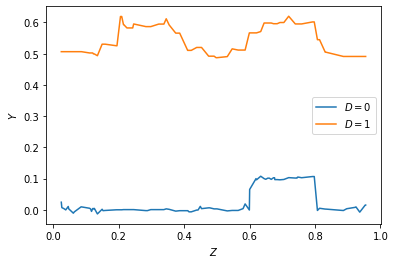

In [29]:
inds = np.argsort(nuisances['train']['Zval'].flatten())
plt.plot(nuisances['train']['Zval'][inds], nuisances['train']['g0'][inds], label='$D=0$')
plt.plot(nuisances['train']['Zval'][inds], nuisances['train']['g1'][inds], label='$D=1$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [16]:
# propensity
mu = clf().fit(Z, D)

[0]	validation_0-logloss:0.65385
[1]	validation_0-logloss:0.61831
[2]	validation_0-logloss:0.58605
[3]	validation_0-logloss:0.55665
[4]	validation_0-logloss:0.52980
[5]	validation_0-logloss:0.50521
[6]	validation_0-logloss:0.48265
[7]	validation_0-logloss:0.46189
[8]	validation_0-logloss:0.44278
[9]	validation_0-logloss:0.42515
[10]	validation_0-logloss:0.40886
[11]	validation_0-logloss:0.39381
[12]	validation_0-logloss:0.37987
[13]	validation_0-logloss:0.36696
[14]	validation_0-logloss:0.35499
[15]	validation_0-logloss:0.34389
[16]	validation_0-logloss:0.33359
[17]	validation_0-logloss:0.32403
[18]	validation_0-logloss:0.31516
[19]	validation_0-logloss:0.30690
[20]	validation_0-logloss:0.29924
[21]	validation_0-logloss:0.29210
[22]	validation_0-logloss:0.28548
[23]	validation_0-logloss:0.27930
[24]	validation_0-logloss:0.27358
[25]	validation_0-logloss:0.26825
[26]	validation_0-logloss:0.26329
[27]	validation_0-logloss:0.25869
[28]	validation_0-logloss:0.25441
[29]	validation_0-loglos

In [17]:
# X-learner
m = mu.predict_proba(Z)[:, 1]
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0])
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]))

[0]	validation_0-rmse:0.06502
[1]	validation_0-rmse:0.06368
[2]	validation_0-rmse:0.06244
[3]	validation_0-rmse:0.06131
[4]	validation_0-rmse:0.06027
[5]	validation_0-rmse:0.05933
[6]	validation_0-rmse:0.05846
[7]	validation_0-rmse:0.05767
[8]	validation_0-rmse:0.05694
[9]	validation_0-rmse:0.05628
[10]	validation_0-rmse:0.05567
[11]	validation_0-rmse:0.05513
[12]	validation_0-rmse:0.05463
[13]	validation_0-rmse:0.05418
[14]	validation_0-rmse:0.05376
[15]	validation_0-rmse:0.05338
[16]	validation_0-rmse:0.05304
[17]	validation_0-rmse:0.05274
[18]	validation_0-rmse:0.05246
[19]	validation_0-rmse:0.05220
[20]	validation_0-rmse:0.05198
[21]	validation_0-rmse:0.05177
[22]	validation_0-rmse:0.05158
[23]	validation_0-rmse:0.05141
[24]	validation_0-rmse:0.05125
[25]	validation_0-rmse:0.05112
[26]	validation_0-rmse:0.05100
[27]	validation_0-rmse:0.05091
[28]	validation_0-rmse:0.05081
[29]	validation_0-rmse:0.05072
[30]	validation_0-rmse:0.05063
[31]	validation_0-rmse:0.05056
[32]	validation_0-

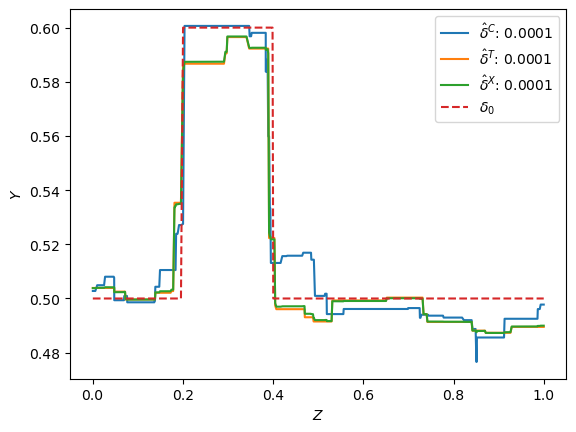

In [18]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label='$\delta_0$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [19]:
# S-Learner
g = reg().fit(np.hstack([D.reshape(-1, 1), Z]), Y)

[0]	validation_0-rmse:0.44901
[1]	validation_0-rmse:0.42692
[2]	validation_0-rmse:0.40596
[3]	validation_0-rmse:0.38606
[4]	validation_0-rmse:0.36719
[5]	validation_0-rmse:0.34928
[6]	validation_0-rmse:0.33229
[7]	validation_0-rmse:0.31618
[8]	validation_0-rmse:0.30090
[9]	validation_0-rmse:0.28640
[10]	validation_0-rmse:0.27267
[11]	validation_0-rmse:0.25963
[12]	validation_0-rmse:0.24729
[13]	validation_0-rmse:0.23558
[14]	validation_0-rmse:0.22450
[15]	validation_0-rmse:0.21400
[16]	validation_0-rmse:0.20406
[17]	validation_0-rmse:0.19464
[18]	validation_0-rmse:0.18574
[19]	validation_0-rmse:0.17731
[20]	validation_0-rmse:0.16935
[21]	validation_0-rmse:0.16181
[22]	validation_0-rmse:0.15471
[23]	validation_0-rmse:0.14799
[24]	validation_0-rmse:0.14167
[25]	validation_0-rmse:0.13568
[26]	validation_0-rmse:0.13006
[27]	validation_0-rmse:0.12475
[28]	validation_0-rmse:0.11977
[29]	validation_0-rmse:0.11506
[30]	validation_0-rmse:0.11067
[31]	validation_0-rmse:0.10651
[32]	validation_0-

In [20]:
# IPS-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauIPS = reg().fit(Z, Y * (D - m)/cov)

[0]	validation_0-rmse:2.16399
[1]	validation_0-rmse:2.16409
[2]	validation_0-rmse:2.16417
[3]	validation_0-rmse:2.16428
[4]	validation_0-rmse:2.16437


In [21]:
# DR-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Z)
g0preds = g0.predict(Z)
gpreds = g1preds * D + g0preds * (1 - D)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDR = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.20112
[1]	validation_0-rmse:0.20069
[2]	validation_0-rmse:0.20030
[3]	validation_0-rmse:0.19995
[4]	validation_0-rmse:0.19963
[5]	validation_0-rmse:0.19935
[6]	validation_0-rmse:0.19909
[7]	validation_0-rmse:0.19886
[8]	validation_0-rmse:0.19865
[9]	validation_0-rmse:0.19845
[10]	validation_0-rmse:0.19829
[11]	validation_0-rmse:0.19813
[12]	validation_0-rmse:0.19799
[13]	validation_0-rmse:0.19790
[14]	validation_0-rmse:0.19777
[15]	validation_0-rmse:0.19767
[16]	validation_0-rmse:0.19760
[17]	validation_0-rmse:0.19751
[18]	validation_0-rmse:0.19743
[19]	validation_0-rmse:0.19736
[20]	validation_0-rmse:0.19731
[21]	validation_0-rmse:0.19724
[22]	validation_0-rmse:0.19720
[23]	validation_0-rmse:0.19714
[24]	validation_0-rmse:0.19710
[25]	validation_0-rmse:0.19706
[26]	validation_0-rmse:0.19703
[27]	validation_0-rmse:0.19699
[28]	validation_0-rmse:0.19696
[29]	validation_0-rmse:0.19694
[30]	validation_0-rmse:0.19692
[31]	validation_0-rmse:0.19690
[32]	validation_0-

In [22]:
# R-Learner
h = reg().fit(Z, Y)
Yres = Y - h.predict(Z)
Dres = D - mu.predict_proba(Z)[:, 1]

[0]	validation_0-rmse:0.45220
[1]	validation_0-rmse:0.43141
[2]	validation_0-rmse:0.41173
[3]	validation_0-rmse:0.39312
[4]	validation_0-rmse:0.37553
[5]	validation_0-rmse:0.35891
[6]	validation_0-rmse:0.34320
[7]	validation_0-rmse:0.32837
[8]	validation_0-rmse:0.31439
[9]	validation_0-rmse:0.30120
[10]	validation_0-rmse:0.28877
[11]	validation_0-rmse:0.27706
[12]	validation_0-rmse:0.26605
[13]	validation_0-rmse:0.25569
[14]	validation_0-rmse:0.24597
[15]	validation_0-rmse:0.23684
[16]	validation_0-rmse:0.22828
[17]	validation_0-rmse:0.22026
[18]	validation_0-rmse:0.21275
[19]	validation_0-rmse:0.20574
[20]	validation_0-rmse:0.19919
[21]	validation_0-rmse:0.19308
[22]	validation_0-rmse:0.18738
[23]	validation_0-rmse:0.18209
[24]	validation_0-rmse:0.17717
[25]	validation_0-rmse:0.17260
[26]	validation_0-rmse:0.16836
[27]	validation_0-rmse:0.16444
[28]	validation_0-rmse:0.16082
[29]	validation_0-rmse:0.15747
[30]	validation_0-rmse:0.15438
[31]	validation_0-rmse:0.15153
[32]	validation_0-

In [23]:
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauR = reg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

[0]	validation_0-rmse:0.22521
[1]	validation_0-rmse:0.22484
[2]	validation_0-rmse:0.22450
[3]	validation_0-rmse:0.22420
[4]	validation_0-rmse:0.22392
[5]	validation_0-rmse:0.22366
[6]	validation_0-rmse:0.22343
[7]	validation_0-rmse:0.22321
[8]	validation_0-rmse:0.22302
[9]	validation_0-rmse:0.22285
[10]	validation_0-rmse:0.22269
[11]	validation_0-rmse:0.22254
[12]	validation_0-rmse:0.22241
[13]	validation_0-rmse:0.22229
[14]	validation_0-rmse:0.22218
[15]	validation_0-rmse:0.22208
[16]	validation_0-rmse:0.22198
[17]	validation_0-rmse:0.22193
[18]	validation_0-rmse:0.22185
[19]	validation_0-rmse:0.22177
[20]	validation_0-rmse:0.22170
[21]	validation_0-rmse:0.22164
[22]	validation_0-rmse:0.22161
[23]	validation_0-rmse:0.22156
[24]	validation_0-rmse:0.22151
[25]	validation_0-rmse:0.22148
[26]	validation_0-rmse:0.22144
[27]	validation_0-rmse:0.22141
[28]	validation_0-rmse:0.22139
[29]	validation_0-rmse:0.22135
[30]	validation_0-rmse:0.22134
[31]	validation_0-rmse:0.22131
[32]	validation_0-

In [24]:
# from econml.grf import CausalForest
# tauR = CausalForest(min_samples_leaf=20, max_depth=5, max_samples=.8, inference=False).fit(Z, Dres, Yres)

In [25]:
# DRX-Learner
m = mu.predict_proba(Z)[:, 1]
g0preds = g0.predict(Z)
g1preds = g1.predict(Z)
g0preds = g0preds * (1 - m) + (g1.predict(Z) - tau0.predict(Z)) * m
g1preds = g1preds * m + (g0.predict(Z) + tau1.predict(Z)) * (1 - m)
gpreds = g1preds * D + g0preds * (1 - D)
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDRX = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.20647
[1]	validation_0-rmse:0.20605
[2]	validation_0-rmse:0.20568
[3]	validation_0-rmse:0.20534
[4]	validation_0-rmse:0.20504
[5]	validation_0-rmse:0.20478
[6]	validation_0-rmse:0.20454
[7]	validation_0-rmse:0.20432
[8]	validation_0-rmse:0.20413
[9]	validation_0-rmse:0.20396
[10]	validation_0-rmse:0.20381
[11]	validation_0-rmse:0.20366
[12]	validation_0-rmse:0.20354
[13]	validation_0-rmse:0.20344
[14]	validation_0-rmse:0.20334
[15]	validation_0-rmse:0.20325
[16]	validation_0-rmse:0.20319
[17]	validation_0-rmse:0.20312
[18]	validation_0-rmse:0.20306
[19]	validation_0-rmse:0.20302
[20]	validation_0-rmse:0.20297
[21]	validation_0-rmse:0.20295
[22]	validation_0-rmse:0.20292
[23]	validation_0-rmse:0.20292
[24]	validation_0-rmse:0.20289
[25]	validation_0-rmse:0.20287
[26]	validation_0-rmse:0.20288
[27]	validation_0-rmse:0.20285
[28]	validation_0-rmse:0.20284
[29]	validation_0-rmse:0.20286
[30]	validation_0-rmse:0.20284
[31]	validation_0-rmse:0.20283
[32]	validation_0-

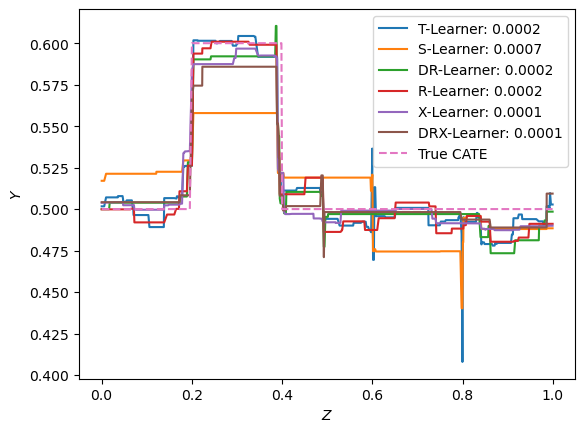

In [26]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
plt.plot(Ztest, tT, label=f'T-Learner: {rmse(cate(Ztest), tT):.4f}')
plt.plot(Ztest, tS, label=f'S-Learner: {rmse(cate(Ztest), tS):.4f}')
# plt.plot(Ztest, tIPS, label='IPS-Learner')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tR, label=f'R-Learner: {rmse(cate(Ztest), tR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [27]:
import scipy

def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss

def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K)/K, jac=grad_q, bounds=[(0, 1)]*K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-12)
    return res.x

def qagg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [28]:
def staragg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    sol = np.zeros(F.shape[1])
    best = np.argmin(ploss)
    sol[best] = 1.0
    best_loss = loss(sol)
    best_sol = sol
    for gamma in np.linspace(0, 1, 100):
        for i in range(F.shape[1]):
            x = (1 - gamma) * sol
            x[i] += gamma
            cur_loss = loss(x)
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_sol = x
    return best_sol

In [29]:
Zval = np.random.uniform(0, 1, size=n)
Dval = np.random.binomial(1, prop(Zval))
Yval = cate(Zval) * Dval + base(Zval) + np.random.normal(0, .05, size=n)

In [30]:
Zval = Zval.reshape(-1, 1)
g0val = reg().fit(Zval[Dval==0], Yval[Dval==0])
g1val = reg().fit(Zval[Dval==1], Yval[Dval==1])
muval = clf().fit(Zval, Dval)
# DR-Learner
m = muval.predict_proba(Zval)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1val.predict(Zval)
g0preds = g0val.predict(Zval)
gpreds = g1preds * Dval + g0preds * (1 - Dval)
Ydrval = (Yval - gpreds) * (Dval - m)/cov + g1preds - g0preds

[0]	validation_0-rmse:0.46066
[1]	validation_0-rmse:0.43799
[2]	validation_0-rmse:0.41646
[3]	validation_0-rmse:0.39602
[4]	validation_0-rmse:0.37662
[5]	validation_0-rmse:0.35822
[6]	validation_0-rmse:0.34074
[7]	validation_0-rmse:0.32416
[8]	validation_0-rmse:0.30842
[9]	validation_0-rmse:0.29350
[10]	validation_0-rmse:0.27935
[11]	validation_0-rmse:0.26592
[12]	validation_0-rmse:0.25319
[13]	validation_0-rmse:0.24113
[14]	validation_0-rmse:0.22969
[15]	validation_0-rmse:0.21885
[16]	validation_0-rmse:0.20858
[17]	validation_0-rmse:0.19886
[18]	validation_0-rmse:0.18966
[19]	validation_0-rmse:0.18094
[20]	validation_0-rmse:0.17270
[21]	validation_0-rmse:0.16490
[22]	validation_0-rmse:0.15753
[23]	validation_0-rmse:0.15057
[24]	validation_0-rmse:0.14399
[25]	validation_0-rmse:0.13778
[26]	validation_0-rmse:0.13193
[27]	validation_0-rmse:0.12641
[28]	validation_0-rmse:0.12121
[29]	validation_0-rmse:0.11631
[30]	validation_0-rmse:0.11171
[31]	validation_0-rmse:0.10739
[32]	validation_0-

[45]	validation_0-logloss:0.21173
[46]	validation_0-logloss:0.21061
[47]	validation_0-logloss:0.20959
[48]	validation_0-logloss:0.20862
[49]	validation_0-logloss:0.20776
[50]	validation_0-logloss:0.20694
[51]	validation_0-logloss:0.20618
[52]	validation_0-logloss:0.20550
[53]	validation_0-logloss:0.20486
[54]	validation_0-logloss:0.20429
[55]	validation_0-logloss:0.20374
[56]	validation_0-logloss:0.20324
[57]	validation_0-logloss:0.20280
[58]	validation_0-logloss:0.20235
[59]	validation_0-logloss:0.20198
[60]	validation_0-logloss:0.20160
[61]	validation_0-logloss:0.20125
[62]	validation_0-logloss:0.20095
[63]	validation_0-logloss:0.20066
[64]	validation_0-logloss:0.20039
[65]	validation_0-logloss:0.20015
[66]	validation_0-logloss:0.19993
[67]	validation_0-logloss:0.19973
[68]	validation_0-logloss:0.19953
[69]	validation_0-logloss:0.19938
[70]	validation_0-logloss:0.19922
[71]	validation_0-logloss:0.19907
[72]	validation_0-logloss:0.19896
[73]	validation_0-logloss:0.19883
[74]	validatio

In [31]:
t0 = tau0.predict(Zval)
t1 = tau1.predict(Zval)
tT = g1.predict(Zval) - g0.predict(Zval)
tS = g.predict(np.stack((np.ones(n), Zval.flatten()), -1))
tS -= g.predict(np.stack((np.zeros(n), Zval.flatten()), -1))
tIPS = tauIPS.predict(Zval)
tDR = tauDR.predict(Zval)
tR = tauR.predict(Zval)
m = mu.predict_proba(Zval)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zval)

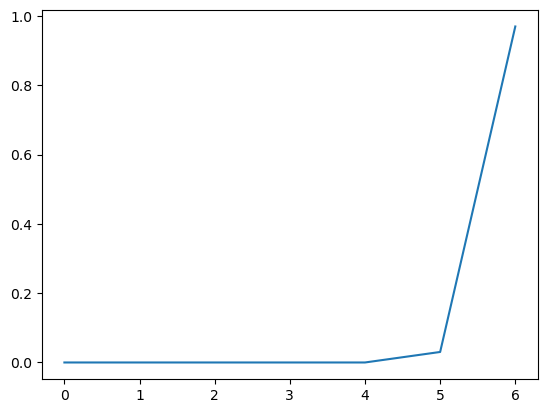

In [32]:
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
weights = qagg(F, Ydrval)
plt.plot(weights)
# weights = staragg(F, Ydrval)
# plt.plot(weights)

In [33]:
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weights):.4f}'

'Ensemble: 0.0001'

In [34]:
weightsBest = np.zeros(weights.shape)
weightsBest[np.argmin(np.mean((Ydrval.reshape(-1, 1) - F)**2, axis=0))] = 1.0
f'Ensemble: {rmse(cate(Zval.flatten()), F @ weightsBest):.4f}'

'Ensemble: 0.0001'

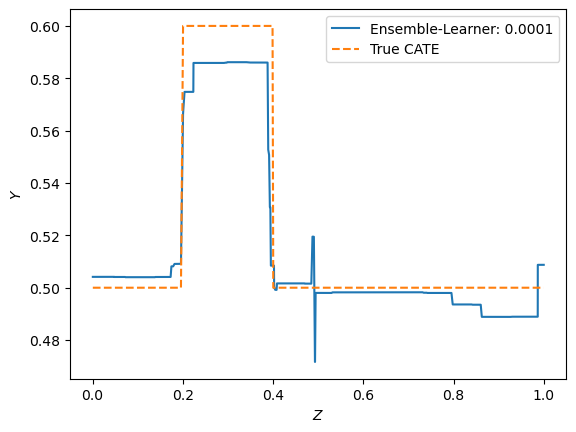

In [35]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
tT = g1.predict(Ztest.reshape(-1, 1)) - g0.predict(Ztest.reshape(-1, 1))
tS = g.predict(np.stack((np.ones(ntest), Ztest), -1)) - g.predict(np.stack((np.zeros(ntest), Ztest), -1))
tIPS = tauIPS.predict(Ztest.reshape(-1, 1))
tDR = tauDR.predict(Ztest.reshape(-1, 1))
tR = tauR.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
tE = F @ weights
plt.plot(Ztest, tE, label=f'Ensemble-Learner: {rmse(cate(Ztest), tE):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [36]:
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauDRXW = reg().fit(Z, Ydr, sample_weight=cov**2)

[0]	validation_0-rmse:0.21841
[1]	validation_0-rmse:0.21835
[2]	validation_0-rmse:0.21829
[3]	validation_0-rmse:0.21824
[4]	validation_0-rmse:0.21819
[5]	validation_0-rmse:0.21814
[6]	validation_0-rmse:0.21810
[7]	validation_0-rmse:0.21806
[8]	validation_0-rmse:0.21803
[9]	validation_0-rmse:0.21800
[10]	validation_0-rmse:0.21797
[11]	validation_0-rmse:0.21794
[12]	validation_0-rmse:0.21791
[13]	validation_0-rmse:0.21789
[14]	validation_0-rmse:0.21787
[15]	validation_0-rmse:0.21785
[16]	validation_0-rmse:0.21783
[17]	validation_0-rmse:0.21781
[18]	validation_0-rmse:0.21780
[19]	validation_0-rmse:0.21778
[20]	validation_0-rmse:0.21777
[21]	validation_0-rmse:0.21775
[22]	validation_0-rmse:0.21774
[23]	validation_0-rmse:0.21773
[24]	validation_0-rmse:0.21772
[25]	validation_0-rmse:0.21771
[26]	validation_0-rmse:0.21770
[27]	validation_0-rmse:0.21769
[28]	validation_0-rmse:0.21769
[29]	validation_0-rmse:0.21768
[30]	validation_0-rmse:0.21767
[31]	validation_0-rmse:0.21767
[32]	validation_0-

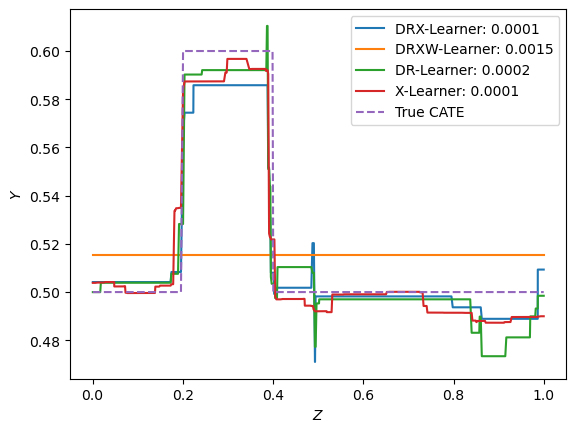

In [37]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tDRXW = tauDRXW.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tDRXW, label=f'DRXW-Learner: {rmse(cate(Ztest), tDRXW):.4f}')
plt.plot(Ztest, tDR, label=f'DR-Learner: {rmse(cate(Ztest), tDR):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [38]:
# post-processing DRX
m = mu.predict_proba(Z)[:, 1]
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
tX = t1 * (1 - m) + t0 * m
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = tX + (Yres - tX * Dres) * Dres / cov
tauDRX = reg().fit(Z, Ydr)

[0]	validation_0-rmse:0.21908
[1]	validation_0-rmse:0.21869
[2]	validation_0-rmse:0.21826
[3]	validation_0-rmse:0.21788
[4]	validation_0-rmse:0.21753
[5]	validation_0-rmse:0.21722
[6]	validation_0-rmse:0.21698
[7]	validation_0-rmse:0.21672
[8]	validation_0-rmse:0.21648
[9]	validation_0-rmse:0.21626
[10]	validation_0-rmse:0.21606
[11]	validation_0-rmse:0.21588
[12]	validation_0-rmse:0.21575
[13]	validation_0-rmse:0.21560
[14]	validation_0-rmse:0.21546
[15]	validation_0-rmse:0.21534
[16]	validation_0-rmse:0.21524
[17]	validation_0-rmse:0.21517
[18]	validation_0-rmse:0.21510
[19]	validation_0-rmse:0.21501
[20]	validation_0-rmse:0.21494
[21]	validation_0-rmse:0.21490
[22]	validation_0-rmse:0.21484
[23]	validation_0-rmse:0.21478
[24]	validation_0-rmse:0.21474
[25]	validation_0-rmse:0.21475
[26]	validation_0-rmse:0.21470
[27]	validation_0-rmse:0.21466
[28]	validation_0-rmse:0.21467
[29]	validation_0-rmse:0.21462
[30]	validation_0-rmse:0.21464
[31]	validation_0-rmse:0.21461
[32]	validation_0-

In [39]:
# post-processing RX
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
m = mu.predict_proba(Z)[:, 1]
tX = t1 * (1 - m) + t0 * m
tauRX = reg().fit(Z, (Yres - tX * Dres) / DresClip, sample_weight=Dres**2)

[0]	validation_0-rmse:0.52983
[1]	validation_0-rmse:0.50862
[2]	validation_0-rmse:0.48867
[3]	validation_0-rmse:0.46992
[4]	validation_0-rmse:0.45231
[5]	validation_0-rmse:0.43579
[6]	validation_0-rmse:0.42031
[7]	validation_0-rmse:0.40581
[8]	validation_0-rmse:0.39225
[9]	validation_0-rmse:0.37958
[10]	validation_0-rmse:0.36775
[11]	validation_0-rmse:0.35673
[12]	validation_0-rmse:0.34647
[13]	validation_0-rmse:0.33692
[14]	validation_0-rmse:0.32806
[15]	validation_0-rmse:0.31983
[16]	validation_0-rmse:0.31221
[17]	validation_0-rmse:0.30515
[18]	validation_0-rmse:0.29863
[19]	validation_0-rmse:0.29261
[20]	validation_0-rmse:0.28705
[21]	validation_0-rmse:0.28194
[22]	validation_0-rmse:0.27723
[23]	validation_0-rmse:0.27290
[24]	validation_0-rmse:0.26892
[25]	validation_0-rmse:0.26527
[26]	validation_0-rmse:0.26193
[27]	validation_0-rmse:0.25886
[28]	validation_0-rmse:0.25606
[29]	validation_0-rmse:0.25349
[30]	validation_0-rmse:0.25115
[31]	validation_0-rmse:0.24903
[32]	validation_0-

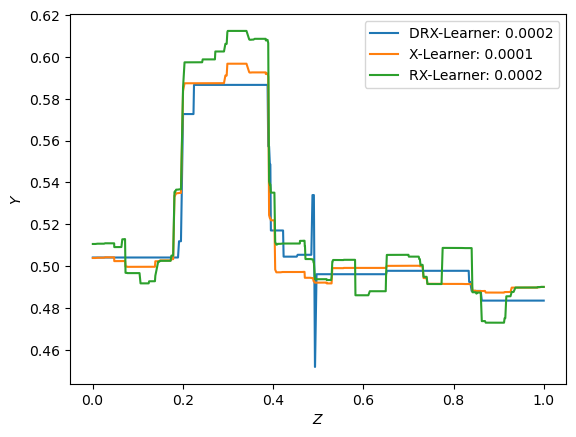

In [40]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tDRX = tauDRX.predict(Ztest.reshape(-1, 1))
tX = t1 * (1 - m) + t0 * m
tRX = tauRX.predict(Ztest.reshape(-1, 1)) + tX
plt.plot(Ztest, tDRX, label=f'DRX-Learner: {rmse(cate(Ztest), tDRX):.4f}')
plt.plot(Ztest, tX,  label=f'X-Learner: {rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, tRX, label=f'RX-Learner: {rmse(cate(Ztest), tRX):.4f}')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [41]:
# correcting for covariate shift in CATE model estimation in X-Learner
m = mu.predict_proba(Z)[:, 1]

g0 = reg().fit(Z[D==0], Y[D==0], sample_weight=(1 - m[D==0]))
g1 = reg().fit(Z[D==1], Y[D==1], sample_weight=m[D==1])
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0], sample_weight=m[D==0]**2 / (1 - m[D==0]))
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]), sample_weight=(1 - m[D==1])**2 / m[D==1])

[0]	validation_0-rmse:0.45941
[1]	validation_0-rmse:0.43664
[2]	validation_0-rmse:0.41502
[3]	validation_0-rmse:0.39450
[4]	validation_0-rmse:0.37502
[5]	validation_0-rmse:0.35653
[6]	validation_0-rmse:0.33898
[7]	validation_0-rmse:0.32233
[8]	validation_0-rmse:0.30653
[9]	validation_0-rmse:0.29154
[10]	validation_0-rmse:0.27732
[11]	validation_0-rmse:0.26384
[12]	validation_0-rmse:0.25106
[13]	validation_0-rmse:0.23894
[14]	validation_0-rmse:0.22745
[15]	validation_0-rmse:0.21656
[16]	validation_0-rmse:0.20625
[17]	validation_0-rmse:0.19648
[18]	validation_0-rmse:0.18723
[19]	validation_0-rmse:0.17848
[20]	validation_0-rmse:0.17020
[21]	validation_0-rmse:0.16237
[22]	validation_0-rmse:0.15497
[23]	validation_0-rmse:0.14798
[24]	validation_0-rmse:0.14137
[25]	validation_0-rmse:0.13514
[26]	validation_0-rmse:0.12927
[27]	validation_0-rmse:0.12373
[28]	validation_0-rmse:0.11851
[29]	validation_0-rmse:0.11361
[30]	validation_0-rmse:0.10899
[31]	validation_0-rmse:0.10466
[32]	validation_0-

[37]	validation_0-rmse:0.05211
[38]	validation_0-rmse:0.05209
[39]	validation_0-rmse:0.05215
[40]	validation_0-rmse:0.05213


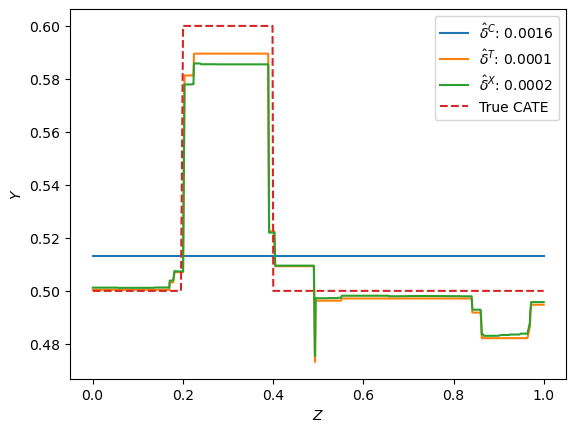

In [42]:
t0 = tau0.predict(Ztest.reshape(-1, 1))
t1 = tau1.predict(Ztest.reshape(-1, 1))
m = mu.predict_proba(Ztest.reshape(-1, 1))[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(Ztest, t0,  label='$\hat{\delta}^C$: ' + f'{rmse(cate(Ztest), t0):.4f}')
plt.plot(Ztest, t1, label='$\hat{\delta}^T$: ' + f'{rmse(cate(Ztest), t1):.4f}')
plt.plot(Ztest, tX,  label='$\hat{\delta}^X$: ' + f'{rmse(cate(Ztest), tX):.4f}')
plt.plot(Ztest, cate(Ztest), '--', label=f'True CATE')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [43]:
# from sklearn.model_selection import cross_val_predict, KFold

# m = cross_val_predict(clf(), Z, D, method='predict_proba')[:, 1]
# g0preds, g1preds = np.zeros(Y.shape), np.zeros(Y.shape)
# for train, test in KFold().split(Z, D):
#     g1preds[test] = reg().fit(Z[train][D[train]==1], Y[train][D[train]==1]).predict(Z[test])
#     g0preds[test] = reg().fit(Z[train][D[train]==0], Y[train][D[train]==0]).predict(Z[test])

# gpreds = g1preds * D + g0preds * (1 - D)
# Ydr = (Y - gpreds) * (D - m)/(m * (1 - m)) + g1preds - g0preds
# tauDR = reg().fit(Z, Ydr)

In [44]:
# grid = np.linspace(0, 1, 20)

# t0 = tau0.predict(grid.reshape(-1, 1))
# t1 = tau1.predict(grid.reshape(-1, 1))
# tDR = tauDR.predict(grid.reshape(-1, 1))
# m = mu.predict_proba(grid.reshape(-1, 1))[:, 1]
# plt.plot(grid, tDR, label='DR-Learner')
# plt.plot(grid, t1 * (1 - m) + t0 * m,  label='X-Learner')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()